# Black-box optimization exercise

## Introduction

This is part of the capstone project for the Professional Certificate in Machine Learning and AI from Imperial College Business School.

The goal is the optimization of 8 black-box functions. For each of the functions 10 initial data points are given and each week I must submit a new data point to evaluate. This simulates a costly process of actual evaluation.

All variables range from 0 to 1.

This notebook will document the whole process. It is structured in a way that follows, function by function and week by week, the thought process and techniques used.

This kind of problem is the textbook example of usage of Bayesian optimization. 

In this kind of problem the most widely used surrogate function is a Gaussian process because, among other things, it already comes with uncertainty measures embedded. I will be testing our different kernels and acquisition functions depending on the case at hand. The litterature suggests applying. Automatic relevance determination (ARD) to the kernels which allows for differnet "length scale" for each dimension. 

## Overview

The challenge provided a certain number of initial points for all 8 functions and then, after each submission, files containing the results a provided.

In this notebook, a dataframe called results_df contains all such results, however they are loaded progressively week by week into variables called fx_inputs and fx_outputs, so as to guarantee that progressive data acquisition can be reproduced throught this notebook. It is therefore very important that all cells are executed in order.

The main approach has been the use of Gaussian Processes as surrogate functions in a Bayesian estimate approach. Some Support Vector Machines and even Dense Neural Networks have been used to explore the classification of the space between "good" and "bad" areas. Some of the early submissions are even based on manual sampling of the unexplored space.

Week 6 marks the point when I look back on functions 4-8 and reapply whatever worked the last time an improvement was found.

Building on these insights, week 8 marked the beginning of an effort to emulate the stratified search strategies of leading NeurIPS Black Box Optimization approaches, particularly TuRBO-style adaptive trust-region methods, integrating their decaying-radius dynamics into my own experimental framework.

### Environment preparation

In [1]:
# Environment preparation, all libs imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install pydot
from IPython.display import Image, display
import os
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import qmc
from scipy.stats import norm as normal_dist
from skopt import forest_minimize
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import ast, re
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models
import torch
import math
import numpy as np
from dataclasses import dataclass
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.generation import MaxPosteriorSampling

In [2]:
#Environment preparation, setting deterministic randomness

def set_global_seed(seed: int = 42):
    import os
    import random
    import numpy as np

    random.seed(seed)

    np.random.seed(seed)

    try:
        import torch

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        try:
            torch.use_deterministic_algorithms(True)
        except Exception:
            pass
    except ImportError:
        pass


    try:
        import tensorflow as tf

        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["PYTHONHASHSEED"] = str(seed)

        tf.random.set_seed(seed)

        # Keras (for older versions)
        try:
            from tensorflow.keras import backend as K
            K.clear_session()
        except Exception:
            pass
    
    except ImportError:
        pass

set_global_seed(42)

In [3]:
# Environment preparation, populating `results_df`, which is a dataframe with all the results known for all functions

results_df = pd.DataFrame(columns=['week', 'function', 'known_best', 'provided_input', 'output', 'submission_improved'])

# Load initial values
for X in range(1, 9):
    inputs_path = f"initial_data/function_{X}/initial_inputs.npy"
    outputs_path = f"initial_data/function_{X}/initial_outputs.npy"
    
    globals()[f"f{X}_inputs"] = np.load(inputs_path)
    globals()[f"f{X}_outputs"] = np.load(outputs_path)

    results_df.loc[len(results_df)] = [0, X, np.max(globals()[f"f{X}_outputs"]), globals()[f"f{X}_inputs"][np.argmax(globals()[f"f{X}_outputs"])], np.nan, False]

# Load results dataframe with each weeks inputs and outputs
#for X in range(1,3):
inputs_path = f"submissions/w12_inputs.txt"
outputs_path = f"submissions/w12_outputs.txt"

#Inputs
with open(inputs_path, 'r') as file:
    content = file.read()

# Split out the separate sets
raw_sets = re.split(r'\]\s*\[', content.strip())
raw_sets = [s.strip('[]') for s in raw_sets]

# Parse each set into lists of numpy arrays
all_sets = []
for s in raw_sets:
    arrays_raw = re.findall(r'array\((.*?)\)', s, re.DOTALL)
    instance_set = [np.array(eval(a)) for a in arrays_raw]
    all_sets.append(instance_set)

# Transpose structure: arrays[i] has i-th array of each set
max_len = max(len(s) for s in all_sets)
arrays = []
for i in range(max_len):
    group = []
    for n, s in enumerate(all_sets, start=1):
        if i < len(s):
            #week number, function, best_output, provided_input, output, submission_improved
            results_df.loc[len(results_df)] = [n, i+1, np.nan, s[i], np.nan, False]
    
#Outputs
with open(outputs_path, 'r') as file:
    for line_number, line in enumerate(file, start=1):
        content = line.strip()

        # Replace 'np.float64(' and ')' so the string only has floats, then use ast.literal_eval for safety
        content_clean = content.replace('np.float64(', '').replace(')', '')
        float_list = ast.literal_eval(f'[{content_clean}]')

        outputs = np.array(float_list, dtype=np.float64)

        # for each function
        for i in range(0,8):
            #Determine if the submission if best than the known best previous week (hence the -1)
            row = results_df[(results_df['week'] == line_number-1) & (results_df['function'] == i+1)]
            known_best = row['known_best'].values[0]
        
            improved = (outputs[0,i] > known_best)
            if improved:
                known_best = outputs[0,i]
            # populate the dataframe
            condition = (results_df['week'] == line_number) & (results_df['function'] == i+1)
            results_df.loc[condition, 'submission_improved'] = improved
            results_df.loc[condition, 'known_best'] = known_best
            results_df.loc[condition, 'output'] = outputs[0,i]

#### Definition of the TuRBO functions and data structure

This uses a TuRBO algorithm with a dynamic trust region with aggressivie decay and a choice of an GP proces with RBF kernel (default) or Mattern with parameter 2.5. It defaults to Thompsont sampling but can accept a parameter to switch to Expected Improvement.

In [4]:
# Environment preparation, definition of TuRBO functions

## Botorch / TurBO optimization
@dataclass
class TurboState:
    dim: int
    batch_size: int = 1
    length: float = 0.5          # Initial size: 0.5 (Searching 50% of the space around best point)
    length_min: float = 0.05    # should never drop below this    
    length_max: float = 1       # 1 is the whole scope of the dimension      
    failure_counter: int = 0     
    failure_tolerance: int = 1   # Decay immediately if 1 attempt fails instead of the usual higher tolerance
    success_counter: int = 0     
    success_tolerance: int = 2   # Expand after 2 successes
    best_value: float = -float("inf")
    restart_triggered: bool = False
    remaining_budget: int = 0 

def update_state_from_history(state, Y_history):
    """
    Safer, budget-aware Trust Region update.
    Call this AFTER adding a new point to your history.
    """
    if len(Y_history) == 0:
        return state

    # Latest observation and previous best
    Y_latest = float(Y_history[-1].item())
    prev_best = float(state.best_value)

    # Absolute + relative tolerance for improvement (robust to noise)
    abs_tol = 1e-3
    rel_tol = 1e-6
    improved = (Y_latest > prev_best + max(abs_tol, rel_tol * abs(prev_best)))

    if improved:
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    # Expand only after sustained success and if budget allows
    if state.success_counter >= state.success_tolerance and state.remaining_budget > 2:
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0

    # Shrink only after sustained failures, and be gentler when budget is low
    elif state.failure_counter >= state.failure_tolerance:
        if state.remaining_budget <= 3:
            # Gentle shrink near the end of budget
            state.length = max(state.length / 1.5, state.length_min)
        else:
            state.length = max(state.length / 2.0, state.length_min)
        state.failure_counter = 0

    # Always track true best
    if Y_history.max().item() > state.best_value:
        state.best_value = Y_history.max().item()

    # Trigger restart if trust region collapses but budget remains
    if state.length <= state.length_min and state.remaining_budget > 0:
        state.restart_triggered = True

    return state

def get_next_suggestion(X_known, Y_known, state, kernel="RBF", sampling="ts"):
    """
    1. Fits GP on known data (with numerical safeguards).
    2. Calculates Trust Region around best point.
    3. Suggests next candidate via Thompson Sampling.
    """

    # Device management
    tkwargs = {
        "dtype": torch.double,
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }

    # Convert numpy to torch if needed
    if isinstance(X_known, np.ndarray):
        X_known = torch.tensor(X_known, **tkwargs)
    if isinstance(Y_known, np.ndarray):
        Y_known = torch.tensor(Y_known, **tkwargs).reshape(-1, 1)

    # Normalize outputs
    train_Y = (Y_known - Y_known.mean()) / (Y_known.std() + 1e-9)

    # ---- GP FIT WITH NUMERICAL SAFEGUARDS ----
    from botorch.models import SingleTaskGP
    from botorch.models.transforms import Standardize
    from gpytorch.mlls import ExactMarginalLogLikelihood
    from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
    from gpytorch.priors import GammaPrior
    from botorch.fit import fit_gpytorch_mll
    from botorch.generation import MaxPosteriorSampling
    from botorch.acquisition import LogExpectedImprovement
    import gpytorch

    # ---- KERNEL SELECTION ----
    if kernel.lower() in ["matern", "mattern"]:
        covar_module = ScaleKernel(
            MaternKernel(
                nu=2.5,
                ard_num_dims=X_known.shape[-1],
                lengthscale_prior=GammaPrior(3.0, 6.0),
            )
        )
    else:
        # Default: behave exactly as before (RBF)
        covar_module = None

    model = SingleTaskGP(
        X_known,
        train_Y,
        covar_module=covar_module,
        outcome_transform=Standardize(m=1)
    )

    # Enforce minimum noise for stability
    model.likelihood.noise_covar.register_constraint(
        "raw_noise", gpytorch.constraints.GreaterThan(1e-8)
    )

    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Robust fitting with jitter fallback
    try:
        fit_gpytorch_mll(mll)
    except Exception:
        success = False
        for jitter in [1e-6, 1e-5, 1e-4]:
            try:
                model.likelihood.noise = model.likelihood.noise + jitter
                fit_gpytorch_mll(mll)
                success = True
                break
            except Exception:
                continue

        if not success:
            # Ultimate fallback: return random point in unit cube
            X_rand = np.random.rand(state.dim)
            state.remaining_budget = max(0, state.remaining_budget - 1)
            return X_rand, state

    # ---- TRUST REGION DEFINITION ----
    best_ind = Y_known.argmax().item()
    x_center = X_known[best_ind]

    tr_lb = torch.clamp(x_center - state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + state.length / 2.0, 0.0, 1.0)

    # ---------------- Sampling ----------------
    with torch.no_grad():
        if sampling.lower() == "ei": # Expected improvement
            n_ts_candidates = 256
            ei = LogExpectedImprovement(
                model=model,
                best_f=train_Y.max(),
            )
            X_rand = tr_lb + (tr_ub - tr_lb) * torch.rand(
                n_ts_candidates, state.dim, **tkwargs
            )
            ei_vals = ei(X_rand.unsqueeze(1))
            X_cand = X_rand[ei_vals.argmax()].unsqueeze(0)
        else: # Thompson sampling
            ts = MaxPosteriorSampling(model=model, replacement=False)
            X_cand = ts(
                torch.cat((tr_lb.unsqueeze(0), tr_ub.unsqueeze(0))),
                num_samples=1
            )

    # Decrease remaining budget
    state.remaining_budget = max(0, state.remaining_budget - 1)

    return X_cand.cpu().numpy().flatten(), state


def trigger_restart(state, X_known, Y_known):
    # Reset length to an exploratory size, optionally sample a few random points to choose a new center
    state.length = min(0.5, state.length_max)  # moderate restart radius
    state.failure_counter = 0
    state.success_counter = 0
    state.restart_triggered = False

    # Optionally select a new center by sampling a few random points in [0,1]^d
    n_candidates = min(10, max(5, state.dim * 2))
    cand = np.random.rand(n_candidates, state.dim)
    # Evaluate GP posterior mean at candidates (if GP exists) and pick highest predicted mean
    # If GP not available or unreliable, pick candidate with farthest distance from known points
    return state, cand

In [5]:
# Environment preparation, definition of random hypercube sampling function

import numpy as np

def generate_space_filling_design(dim, n, method="lhs", seed=42):
    """
    Generate well-distributed pseudo-random points in [0,1]^dim.

    Parameters
    ----------
    dim : int
        Number of dimensions.
    n : int
        Number of points.
    method : str
        One of: ["lhs", "sobol", "halton", "hammersley", "maxpro"], as outlined in the JetBrains paper
    seed : int
        Random seed for reproducibility.
    """

    method = method.lower()
    rng = np.random.default_rng(seed)

    # -----------------------------
    # Latin Hypercube Sampling
    # -----------------------------
    if method == "lhs":
        try:
            from scipy.stats import qmc
            sampler = qmc.LatinHypercube(d=dim, seed=seed)
            X = sampler.random(n)
        except ImportError:
            raise ImportError("SciPy ≥1.7 required for Latin Hypercube Sampling.")

    # -----------------------------
    # Sobol Sequence
    # -----------------------------
    elif method == "sobol":
        try:
            from scipy.stats import qmc
            sampler = qmc.Sobol(d=dim, scramble=True, seed=seed)
            X = sampler.random(n)
        except ImportError:
            raise ImportError("SciPy ≥1.7 required for Sobol sequences.")

    # -----------------------------
    # Halton Sequence
    # -----------------------------
    elif method == "halton":
        try:
            from scipy.stats import qmc
            sampler = qmc.Halton(d=dim, scramble=True, seed=seed)
            X = sampler.random(n)
        except ImportError:
            raise ImportError("SciPy ≥1.7 required for Halton sequences.")

    # -----------------------------
    # Hammersley Sequence
    # -----------------------------
    elif method == "hammersley":
        try:
            from scipy.stats import qmc
            sampler = qmc.Hammersley(d=dim)
            X = sampler.random(n)
        except ImportError:
            raise ImportError("SciPy ≥1.7 required for Hammersley sequences.")

    # -----------------------------
    # MaxPro Design (approximate)
    # -----------------------------
    elif method == "maxpro":
        try:
            from scipy.stats import qmc
            from scipy.spatial.distance import pdist

            sampler = qmc.LatinHypercube(d=dim, seed=seed)
            X = sampler.random(n)

            # Improve design by maximizing minimum pairwise distance
            best_X = X.copy()
            best_score = np.min(pdist(X))

            n_iter = 100  # optimization budget
            for _ in range(n_iter):
                X_try = sampler.random(n)
                score = np.min(pdist(X_try))
                if score > best_score:
                    best_score = score
                    best_X = X_try.copy()

            X = best_X

        except ImportError:
            raise ImportError("SciPy required for MaxPro approximation.")

    else:
        raise ValueError(
            "Invalid method. Choose from: "
            "['lhs', 'sobol', 'halton', 'hammersley', 'maxpro']"
        )

    return X


In [6]:
# Environment preparation, definition of "furthest point" function

import numpy as np

def select_furthest_point(X_known, X_candidates):
    """
    Select the single candidate point that is furthest from all known points
    using Euclidean distance.

    Parameters
    ----------
    X_known : array-like, shape (n_known, d) or (d,)
        Set of known points in d-dimensional space.
    X_candidates : array-like, shape (n_candidates, d)
        Set of candidate points in the same d-dimensional space.
    """

    # -------------------------------
    # Convert to NumPy arrays
    # -------------------------------
    X_known = np.asarray(X_known, dtype=float)
    X_candidates = np.asarray(X_candidates, dtype=float)

    # -------------------------------
    # Handle single known point case
    # -------------------------------
    if X_known.ndim == 1:
        X_known = X_known.reshape(1, -1)

    if X_candidates.ndim != 2:
        raise ValueError("X_candidates must be a 2D array of shape (n_candidates, d).")

    # -------------------------------
    # Dimension consistency check
    # -------------------------------
    if X_known.shape[1] != X_candidates.shape[1]:
        raise ValueError(
            f"Dimension mismatch: "
            f"X_known has dim {X_known.shape[1]}, "
            f"but X_candidates has dim {X_candidates.shape[1]}"
        )

    # -------------------------------
    # Compute Euclidean distances
    # Shape: (n_candidates, n_known)
    # -------------------------------
    diff = X_candidates[:, None, :] - X_known[None, :, :]
    distances = np.linalg.norm(diff, axis=2)

    # -------------------------------
    # For each candidate:
    # distance to its nearest known point
    # -------------------------------
    min_distances = np.min(distances, axis=1)

    # -------------------------------
    # Select the candidate with
    # the maximum of that minimum distance
    # -------------------------------
    best_index = np.argmax(min_distances)
    best_point = X_candidates[best_index]

    return best_point


### Observation of weekly results

In [7]:
results_df.sort_values(by=['function', 'week'])

results_df[results_df['week'] == 1]

,week,function,known_best,provided_input,output,submission_improved
8,1,1,7.710875e-16,"[0.373737, 0.232323]",-3.425816e-28,False
20,1,2,6.112052e-01,"[0.818182, 0.979798]",1.117392e-01,False
32,1,3,-3.483531e-02,"[0.172414, 0.206897, 0.206897]",-1.475633e-01,False
44,1,4,-5.117018e-02,"[0.448276, 0.413793, 0.37931, 0.37931]",-5.117018e-02,True
56,1,5,1.687380e+03,"[0.586207, 0.62069, 1.0, 0.931034]",1.687380e+03,True
68,1,6,-7.142649e-01,"[0.0, 0.655172, 0.103448, 0.931034, 0.275862]",-1.529715e+00,False
80,1,7,1.367086e+00,"[0.014182, 0.276863, 0.738085, 0.05311, 0.3758...",1.367086e+00,True
92,1,8,9.905913e+00,"[0.053588, 0.199773, 0.0651, 0.022307, 0.89028...",9.905913e+00,True


In [8]:
results_df[results_df['week'] == 2]

,week,function,known_best,provided_input,output,submission_improved
9,2,1,7.710875e-16,"[0.989899, 0.767677]",-3.043130e-105,False
21,2,2,6.112052e-01,"[0.707071, 0.10101]",5.755701e-01,False
33,2,3,-3.483531e-02,"[0.862069, 0.137931, 0.655172]",-1.405773e-01,False
45,2,4,6.230694e-01,"[0.413793, 0.413793, 0.344828, 0.413793]",6.230694e-01,True
57,2,5,1.687380e+03,"[0.894898, 0.105102, 0.894898, 0.894898]",1.488865e+03,False
69,2,6,-4.072034e-01,"[0.517241, 0.310345, 0.517241, 0.862069, 0.103...",-4.072034e-01,True
81,2,7,1.599912e+00,"[0.016974, 0.324003, 0.154628, 0.172541, 0.388...",1.599912e+00,True
93,2,8,9.908052e+00,"[0.076967, 0.216041, 0.229342, 0.023042, 0.977...",9.908052e+00,True


In [9]:
results_df[results_df['week'] == 3]


,week,function,known_best,provided_input,output,submission_improved
10,3,1,7.710875e-16,"[0.818182, 0.979798]",8.656108e-113,False
22,3,2,6.669888e-01,"[0.693605, 0.805808]",6.669888e-01,True
34,3,3,-3.483531e-02,"[0.507468, 0.006386, 0.305268]",-1.296685e-01,False
46,3,4,6.230694e-01,"[0.471861, 0.446201, 0.136768, 0.434511]",-5.280037e+00,False
58,3,5,1.687380e+03,"[0.45264, 0.433354, 0.202919, 0.441704]",8.665691e+01,False
70,3,6,-4.072034e-01,"[0.493775, 0.266439, 0.665329, 1.0, 0.266425]",-6.037058e-01,False
82,3,7,1.599912e+00,"[0.015145, 0.20482, 0.115783, 0.977408, 0.4150...",1.575459e-02,False
94,3,8,9.938326e+00,"[0.054303, 0.023167, 0.046826, 0.146788, 0.981...",9.938326e+00,True


In [10]:
results_df[results_df['week'] == 4]

,week,function,known_best,provided_input,output,submission_improved
11,4,1,7.710875e-16,"[0.871653, 0.585572]",1.250482e-43,False
23,4,2,6.669888e-01,"[0.688772, 0.849196]",5.631154e-01,False
35,4,3,-1.494250e-03,"[0.589937, 0.603952, 0.435945]",-1.494250e-03,True
47,4,4,6.230694e-01,"[0.571931, 1.0, 1.0, 0.0]",-3.676854e+01,False
59,4,5,1.687380e+03,"[0.0177, 0.472569, 0.49207, 0.597183]",3.713125e+01,False
71,4,6,-4.072034e-01,"[0.48231, 0.418871, 0.20131, 0.981559, 0.0]",-9.820758e-01,False
83,4,7,1.599912e+00,"[0.036332, 0.920708, 0.509829, 0.218803, 0.361...",2.969508e-01,False
95,4,8,9.938326e+00,"[0.229166, 0.133413, 0.151014, 0.018894, 0.960...",9.919728e+00,False


In [11]:
results_df[results_df['week'] == 5]

,week,function,known_best,provided_input,output,submission_improved
12,5,1,2.675288e-09,"[0.5, 0.5]",2.675288e-09,True
24,5,2,6.669888e-01,"[0.696738, 0.300878]",6.459308e-01,False
36,5,3,-1.494250e-03,"[0.593114, 0.448446, 0.293211]",-7.525400e-02,False
48,5,4,6.230694e-01,"[0.305616, 0.434746, 0.456803, 0.473341]",-1.981731e+00,False
60,5,5,3.997541e+03,"[1.0, 0.0, 1.0, 0.965517]",3.997541e+03,True
72,5,6,-4.072034e-01,"[0.241379, 0.310345, 0.689655, 0.931034, 0.103...",-4.698626e-01,False
84,5,7,1.599912e+00,"[0.020515, 0.735827, 0.008273, 0.047345, 0.254...",1.525320e-01,False
96,5,8,9.938326e+00,"[0.066684, 0.029599, 0.012412, 0.855233, 0.692...",8.764698e+00,False


In [12]:
results_df[results_df['week'] == 6]

,week,function,known_best,provided_input,output,submission_improved
13,6,1,2.675288e-09,"[0.3, 0.2]",-5.731956e-46,False
25,6,2,6.669888e-01,"[0.9, 0.5]",1.428735e-01,False
37,6,3,-1.494250e-03,"[0.58787, 0.097176, 0.615007]",-1.211412e-01,False
49,6,4,6.401552e-01,"[0.413793, 0.413793, 0.37931, 0.413793]",6.401552e-01,True
61,6,5,8.662483e+03,"[1.0, 1.0, 1.0, 1.0]",8.662483e+03,True
73,6,6,-4.072034e-01,"[1.0, 0.275862, 0.551724, 0.965517, 0.103448]",-1.015562e+00,False
85,6,7,1.745889e+00,"[0.02296, 0.309007, 0.044995, 0.22857, 0.37374...",1.745889e+00,True
97,6,8,9.965935e+00,"[0.114264, 0.021028, 0.121483, 0.106097, 0.962...",9.965935e+00,True


In [13]:
results_df[results_df['week'] == 7]

,week,function,known_best,provided_input,output,submission_improved
14,7,1,2.675288e-09,"[0.431945, 0.336165]",-0.000006,False
26,7,2,6.669888e-01,"[0.694476, 1.0]",0.600682,False
38,7,3,-1.494250e-03,"[1.0, 1.0, 0.845088]",-0.071932,False
50,7,4,6.401552e-01,"[0.163793, 0.163793, 0.12931, 0.163793]",-11.401662,False
62,7,5,8.662483e+03,"[0.0, 0.0, 1.0, 1.0]",1616.642500,False
74,7,6,-4.072034e-01,"[0.767241, 0.560345, 0.767241, 1.0, 0.353448]",-1.135971,False
86,7,7,1.745889e+00,"[0.0, 0.059007, 0.0, 0.0, 0.123746, 0.484246]",0.387303,False
98,7,8,9.965935e+00,"[0.0, 0.0, 0.0, 0.0, 0.712154, 0.224473, 0.0, ...",9.721742,False


## Function 1

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong and weak sources.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

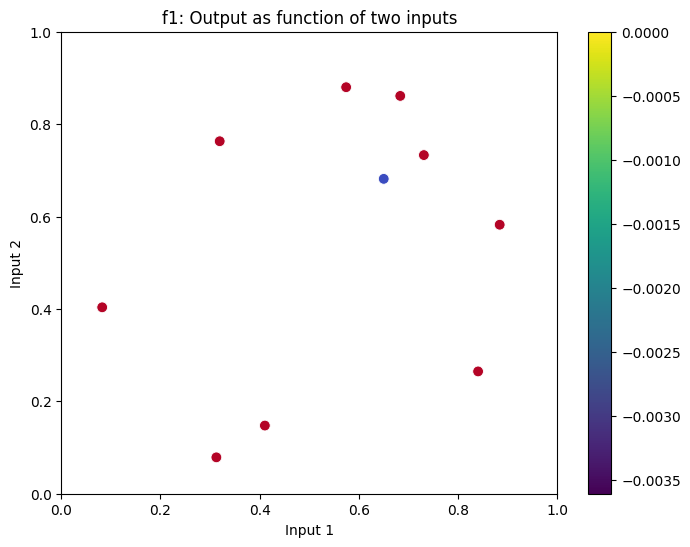

Evaluations: 10
Inputs shape: (10, 2)
Inputs range: [0.0787, 0.8839]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [14]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

Most values are rather on the lower end, which is normal because radiation will be low outside the contaminated area. Peaks are expected to be localized.

We can try a Matern kernel in a Gaussian process regressor to consider that data is not smooth, with a smart selection of nu. If nu tends to infinity, then this behaves as a RBF kernel (reference: https://andrewcharlesjones.github.io/journal/matern-kernels.html). We will initially try with a nu of 1.5

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


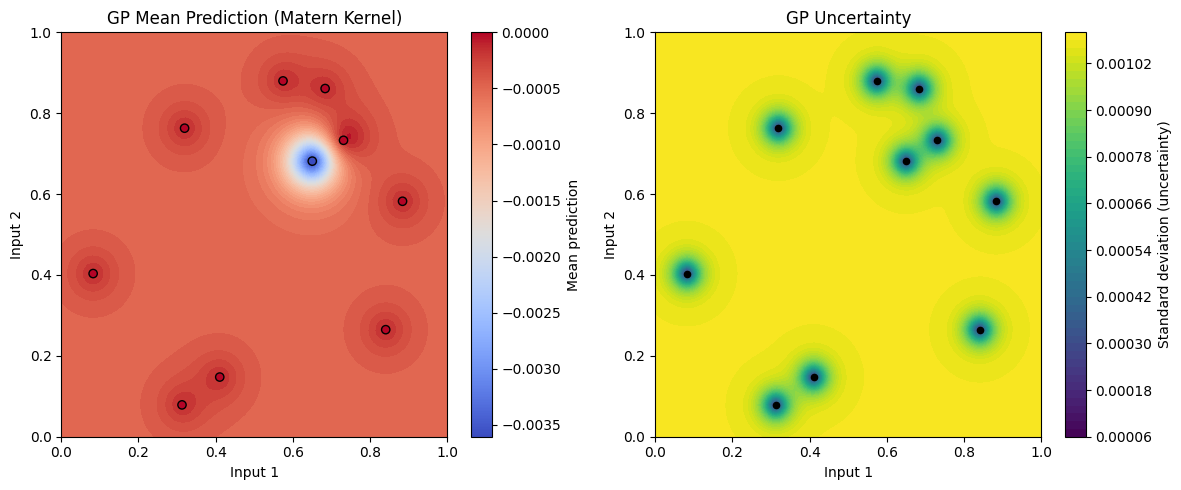

In [15]:
kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(0.05, 0.5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

I am getting warnings about the optimal values being to close to the bounds provided, so let's try again with new values.

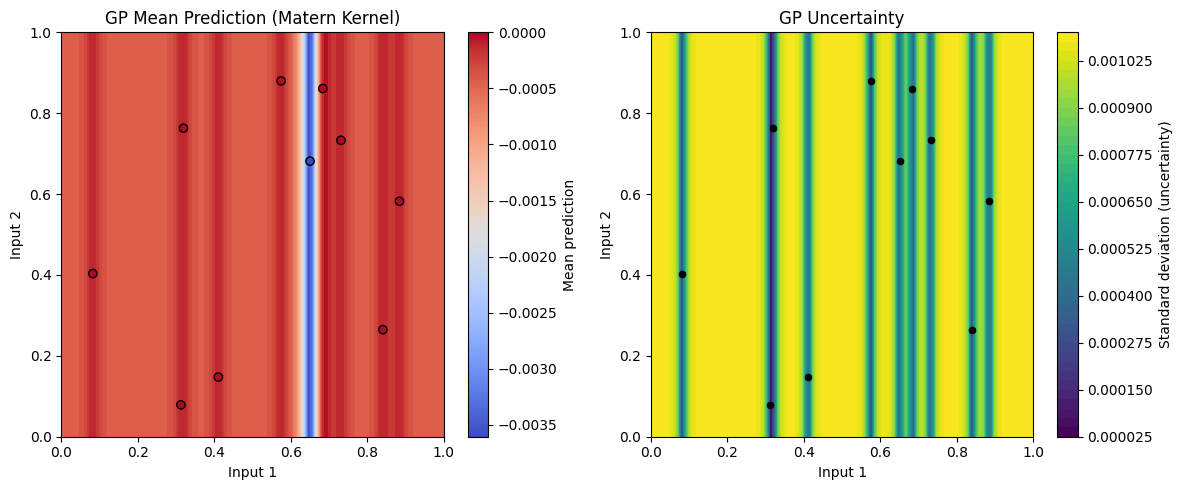

In [16]:

kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(1e-2, 1e5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

As this is a problem that must encourage exploration, let's use a UCB acquisition function, with a choice of k = 3.

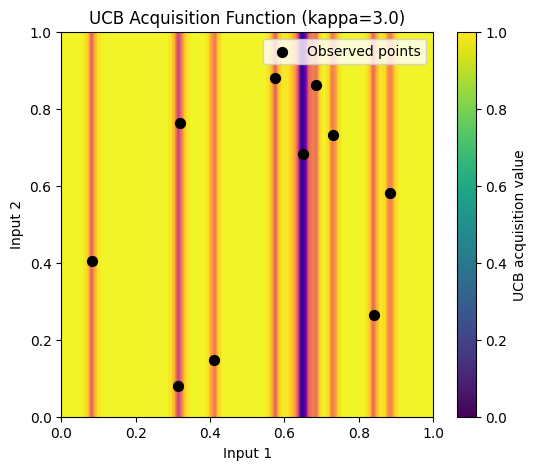

In [17]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [18]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

# With the other bounds the suggested submission was 0.78787879 0.7979798

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.37373737 0.23232323]
0.373737-0.232323


Submission for week 1: 0.373737-0.232323

### Week 2

In [19]:
#Load points to inputs and outputs from previous week
function = 1
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")


Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.4258e-28


Let's try the same thing but adjusting the surrogate function so that the importance is given to both parameters. UCB as acquisition function favors exploration, which is what we want at this point.

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 0.3. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


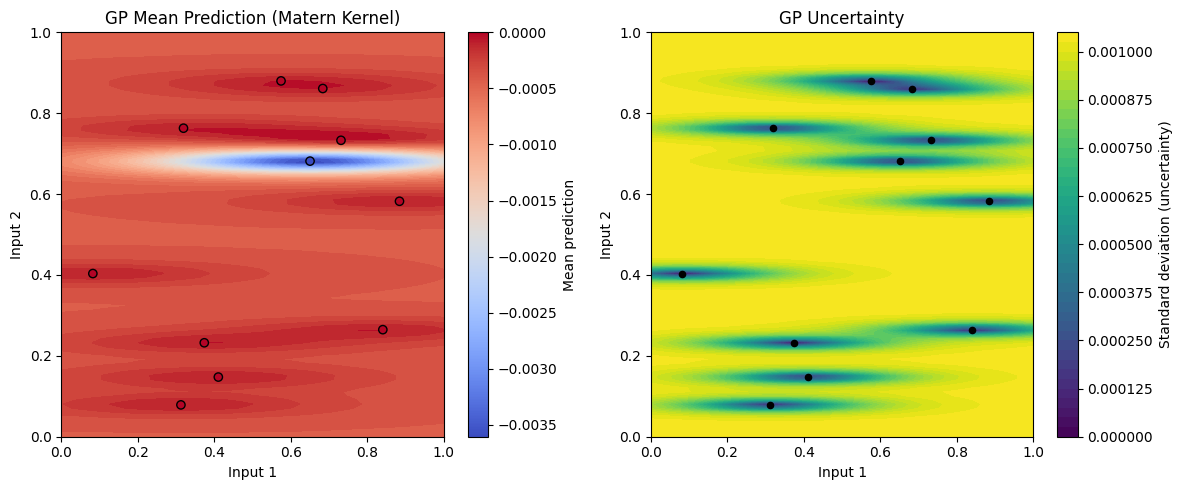

In [20]:

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[0.05, 0.05], length_scale_bounds=(0.01, 0.3), nu=2.5) + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-12, 1e2))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c=f1_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

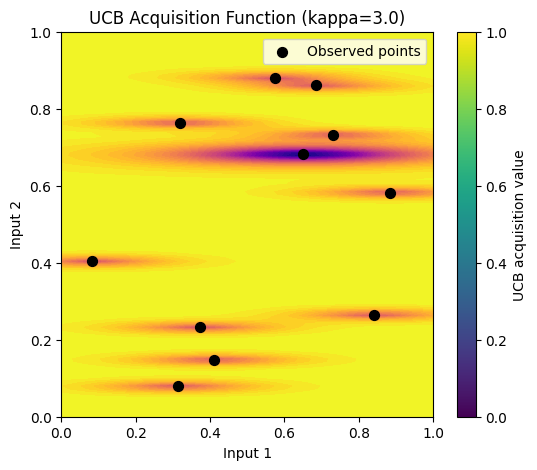

In [21]:
kappa = 3.0
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f1_inputs[:,0], f1_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [22]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next point to sample based on UCB: [0.98989899 0.76767677]
0.989899-0.767677


Submission for week 2: 0.989899-0.767677

### Week 3

In [23]:
#Load points to inputs and outputs from previous week
function = 1
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: -3.0431e-105
--
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


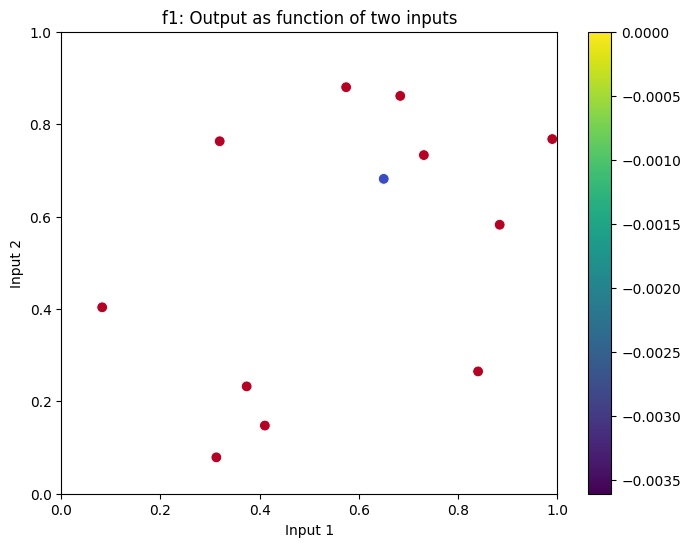

Evaluations: 12
Inputs shape: (12, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [24]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

We haven't had any improvement for this function so far. It is known that values only peak close to a contamination source. One has already been identified (blue dot above), the goal is to determine if other exist in the 2D plane.

In preparation for more complex cases, I am exploring forest_minimize from skopt which efficiently maximizes the value of the acquisition function. This will help also with high-dimensional cases. I am using a L-BFGS-B (Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds), which according to my limited research is optimal for bounded sets of input values.

In [25]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1**2 * Matern(length_scale=[0.00684, 0.0127], nu=1.5)
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next sample point (local optimizer): [0.40501878 0.16214521]
0.405019-0.162145


Submission for week 3: 0.405019-0.162145

### Week 4

In [26]:
#Load points to inputs and outputs from previous week
function = 1
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: 8.6561e-113
--
Inputs shape: (13, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


No improvement has been possible so far. The maximum value is part of the initial values.

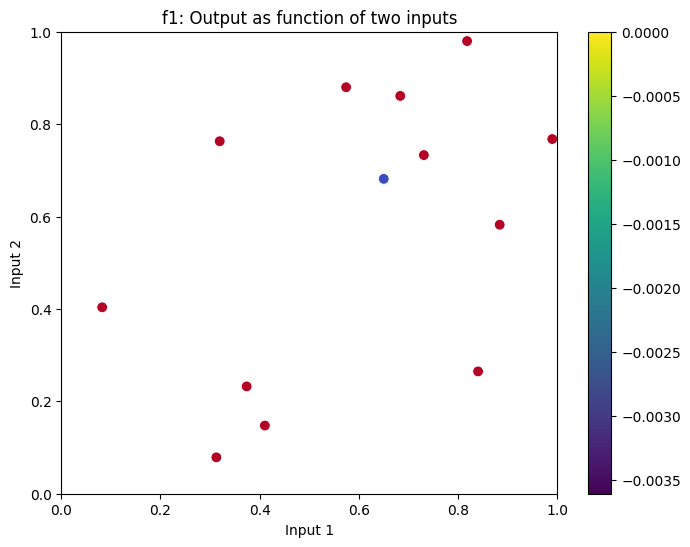

Evaluations: 13
Inputs shape: (13, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]


In [27]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = f1_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

In [28]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

dims = 2
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1**2 * Matern(length_scale=[0.00667, 0.00999], nu=1.5)
Current best: 7.7109e-16
Inputs producing current best: [0.73102363 0.73299988]
Next sample point (ei): [0.30959297 0.09217781]
Next sample point (ucb): [0.87165265 0.58557223]
0.871653-0.585572


I choose the UCB value.

Sample for week 4: 0.871653-0.585572

### Week 5

In [29]:
#Load points to inputs and outputs from previous week
function = 1
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 7.7109e-16
Last week's results: 1.2505e-43
--
Inputs shape: (14, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 7.7109e-16]


Still not found a non-zero reading. The maximum is close to 0. The description of the function cleams that only proximity to a contamination source yield a non-zero reading.

This week I am choosing to sample in the middle of the square:

In [30]:
chosen_point = np.array([0.5, 0.5])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.500000-0.500000


Submissison for week 5: 0.500000-0.500000

### Week 6

In [31]:
#Load points to inputs and outputs from previous week
function = 1
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? True
Current best: 2.6753e-09
Last week's results: 2.6753e-09
--
Inputs shape: (15, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Sampling the middle has yielded the best value so far, slightly positive. 

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_11640\1995708060.py:3: RuntimeWarning: invalid value encountered in log
  y = np.log(f1_outputs)


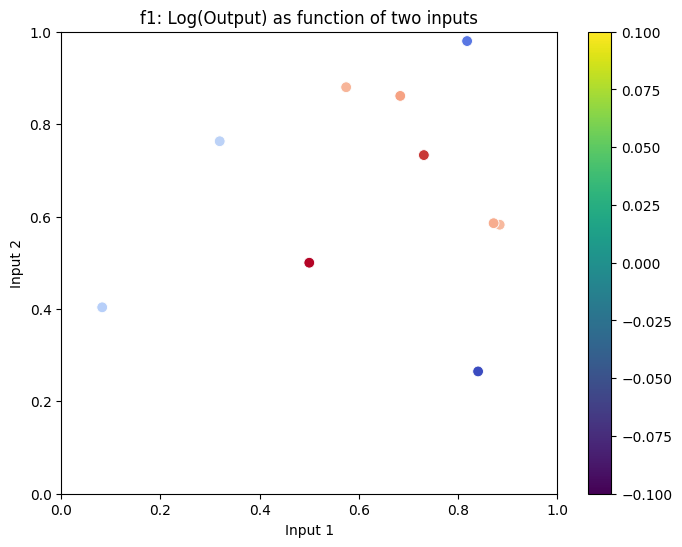

Evaluations: 15
Inputs shape: (15, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]


In [32]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = np.log(f1_outputs)

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Log(Output) as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

I am once again sampling a point with little information selected manually so that I can use those to better approximate the underlying function.

In [33]:
chosen_point = np.array([0.3, 0.2])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.300000-0.200000


Submission for week 6: 0.300000-0.200000

### Week 7

In [34]:
#Load points to inputs and outputs from previous week
function = 1
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: -5.7320e-46
--
Inputs shape: (16, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


This week I am choosing to use another Gaussian process with an UCB aquisition function, now that we have explored a larger part of the plane with a kappa of 1.3.

In [35]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*2, nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=True)

# Fit the GP model
gp.fit(f1_inputs,f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

dims = 2
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.3), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1.09**2 * Matern(length_scale=[2.74e+04, 0.0397], nu=1.5)
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]
Next sample point (ei): [0.05147875 0.33744169]
Next sample point (ucb): [0.43194502 0.33616479]
0.431945-0.336165


Submission for week 7: 0.431945-0.336165

### Week 8

In [36]:
#Load points to inputs and outputs from previous week
function = 1
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: -6.4985e-06
--
Inputs shape: (17, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Let us start using the TuRBO algorithm for this function as well. 

In [37]:
# Initializing the TuRBO state for f1
f1_turbo_state = TurboState(dim=2, best_value=np.max(f1_outputs), failure_tolerance=1, success_tolerance=2)
print(f"Trust Region Size: {f1_turbo_state.length}")

next_suggestion, f1_turbo_state = get_next_suggestion(f1_inputs, f1_outputs, f1_turbo_state)

print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Next point to sample based on TuRBO: [0.25 0.25]
0.250000-0.250000


Submission for week 8: 0.250000-0.250000

### Week 9

In [38]:
#Load points to inputs and outputs from previous week
function = 1
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: 9.7977e-42
--
Inputs shape: (18, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Let us plot the function once again to get an intuitive idea of where I am sampling

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_11640\1995708060.py:3: RuntimeWarning: invalid value encountered in log
  y = np.log(f1_outputs)


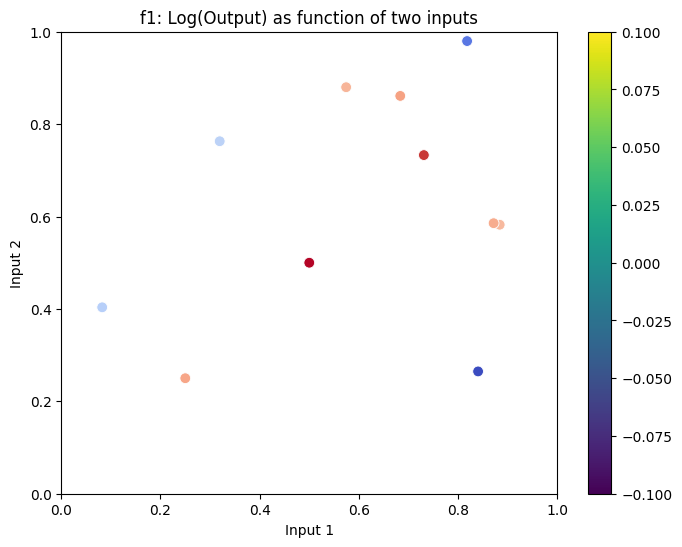

Evaluations: 18
Inputs shape: (18, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]


In [39]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = np.log(f1_outputs)

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Log(Output) as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [40]:
old_length = f1_turbo_state.length
f1_turbo_state = update_state_from_history(f1_turbo_state, f1_outputs)
print(f"Trust Region Size: {f1_turbo_state.length} (Did we decay? {'Yes' if f1_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f1_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f1_outputs[-1].item())}")


next_suggestion, f1_turbo_state = get_next_suggestion(f1_inputs, f1_outputs, f1_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: 2.6752879910742468e-09
Last output as interpreted by TuRBO: 9.797748409814019e-42
Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Next point to sample based on TuRBO: [0.40931064 0.56628188]
0.409311-0.566282


Submission for week 9: 0.409311-0.566282

### Week 10

In [41]:
#Load points to inputs and outputs from previous week
function = 1
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: 1.6435e-15
--
Inputs shape: (19, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Another round of the TuRBO algorithm with the same parameters.

In [42]:
old_length = f1_turbo_state.length
f1_turbo_state = update_state_from_history(f1_turbo_state, f1_outputs)
print(f"Trust Region Size: {f1_turbo_state.length} (Did we decay? {'Yes' if f1_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f1_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f1_outputs[-1].item())}")


next_suggestion, f1_turbo_state = get_next_suggestion(f1_inputs, f1_outputs, f1_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: 2.6752879910742468e-09
Last output as interpreted by TuRBO: 1.6435202857676838e-15
Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Next point to sample based on TuRBO: [0.52720235 0.44646454]
0.527202-0.446465


Submission for week 10: 0.527202-0.446465

### Week 11

In [43]:
#Load points to inputs and outputs from previous week
function = 1
week =10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: -1.5673e-09
--
Inputs shape: (20, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


Another round of the TuRBO algorithm with the same parameters.

In [44]:
old_length = f1_turbo_state.length
f1_turbo_state = update_state_from_history(f1_turbo_state, f1_outputs)
print(f"Trust Region Size: {f1_turbo_state.length} (Did we decay? {'Yes' if f1_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f1_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f1_outputs[-1].item())}")


next_suggestion, f1_turbo_state = get_next_suggestion(f1_inputs, f1_outputs, f1_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? Yes)
Best as known by the TuRBO state: 2.6752879910742468e-09
Last output as interpreted by TuRBO: -1.5673009819887562e-09
Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Next point to sample based on TuRBO: [0.57330137 0.53200854]
0.573301-0.532009


Submission for week 11: 0.573301-0.532009

### Week 12

In [45]:
#Load points to inputs and outputs from previous week
function = 1
week =11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: 2.2774e-09
--
Inputs shape: (21, 2)
Inputs range: [0.0787, 0.9899]
Performance range: [-3.6061e-03, 2.6753e-09]


I only have two samples left, and for this function I have only made one improvement on week 5, when I randomly sampled the center of the square.

My strategy is therefore going to pivot to extreme exploration this week (getting the furthest point from currently known points), followed by a last attempt at Bayesian optimisation.

In [46]:
random_sampling_points = generate_space_filling_design(2, 65536, method="sobol")
next_sample = select_furthest_point(f1_inputs, random_sampling_points)


print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Next point to sample based on random sampling:", next_sample)
print("-".join(f"{x:.6f}" for x in next_sample.flatten()))

Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Next point to sample based on random sampling: [0.00138759 0.9964121 ]
0.001388-0.996412


Submission for week 12: 0.001388-0.996412

### Week 13

In [47]:
#Load points to inputs and outputs from previous week
function = 1
week =12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f1_inputs = np.vstack([f1_inputs, row['provided_input'].values[0]])
f1_outputs = np.append(f1_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Last week's results: {row['output'].values[0]:.4e}")
print('--')
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")

Submission from last week improved something? False
Current best: 2.6753e-09
Last week's results: 0.0000e+00
--
Inputs shape: (22, 2)
Inputs range: [0.0014, 0.9964]
Performance range: [-3.6061e-03, 2.6753e-09]


Last week's random sample has resulted in a strong 0. According to the function description only closeness to the source yields a non-zero reading.

Here is a plot of the current siuation:

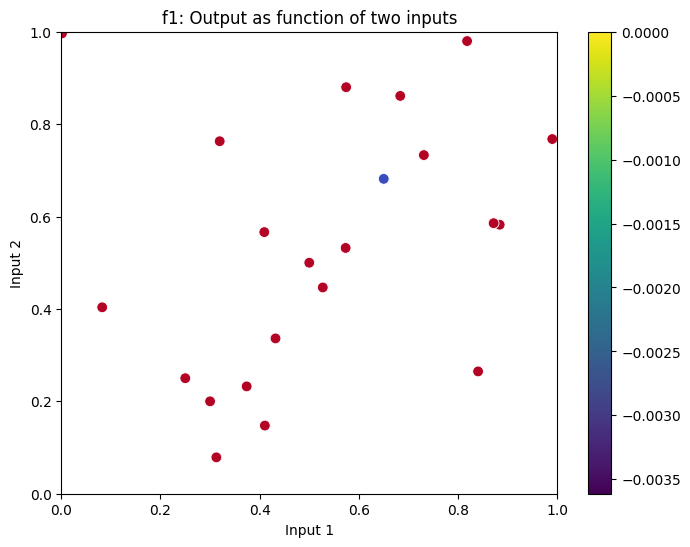

Evaluations: 22
Inputs shape: (22, 2)
Inputs range: [0.0014, 0.9964]
Performance range: [-3.6061e-03, 2.6753e-09]
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]


In [48]:
x1 = f1_inputs[:, 0]
x2 = f1_inputs[:, 1]
y = np.log1p(f1_outputs)

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f1: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f1_inputs)}")
print(f"Inputs shape: {f1_inputs.shape}")
print(f"Inputs range: [{np.min(f1_inputs):.4f}, {np.max(f1_inputs):.4f}]")
print(f"Performance range: [{np.min(f1_outputs):.4e}, {np.max(f1_outputs):.4e}]")
print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

For this last submission, I will try to find a point around the current max (0.5, 0.5) with a higher value. I will select a Gaussian process with expected improvement for this last attempt.

The only sample that has improved the best value from the initial data set was that found when the sample choice was made manually after a visual inspection of the graph.

But just out of curiosity, let me find the current "furthest point from all currently explored points":

In [49]:
random_sampling_points = generate_space_filling_design(2, 65536, method="sobol")
next_sample = select_furthest_point(f1_inputs, random_sampling_points)


print(f"Current best: {np.max(f1_outputs):.4f}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")
print("Found furthest point based on random sampling:", next_sample)

Current best: 0.0000
Inputs producing current best: [0.5 0.5]
Found furthest point based on random sampling: [5.66309318e-05 2.48719007e-04]


I have no particular intention of exploring yet another corner for this last submission. So let us find what a GP can find around (0.5, 0.5)

In [50]:
kernel = Matern(length_scale=[0.1, 0.1], length_scale_bounds=(1e-2, 1e5), nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f1_inputs, f1_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f1_outputs):.4e}")
print(f"Inputs producing current best: {f1_inputs[np.argmax(f1_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Matern(length_scale=[0.0272, 6.16e+04], nu=1.5)
Current best: 2.6753e-09
Inputs producing current best: [0.5 0.5]
Next sample point (local optimizer): [0.69979699 0.89520684]
0.699797-0.895207


This approach is too simplistic and is probably revealing that the Gaussian process is unable to make a good estimation given the peak value found at around 1e-9, super small close to zero values such as -3e105 and them some 0.0 and -0.003. In fact, if you look at the ``length_scale=[0.0272, 6.16e+04]`` of the resulting kernel, the first dimension is very small and the second is huge when compared to the bounds (0,1). 

For this last week, I will try a strategy mainly based on:
* Rescaling, to make it easier to approximate the function and to avoid precision issues.
* More sensible ``length_scale`` values to enforce some smoothness, to try and interpret the radiation source as a cone that we may try to climb, instead of a stripe.
* Maximize the estimated mean instead of using EI as an acquisition function, because this is the final attempt.

In [264]:
# Scaling
scale_factor = 1e9 
f1_outputs_scaled = f1_outputs * scale_factor

print(f"Current best (scaled): {np.max(f1_outputs_scaled):.4e}")

# Force the length_scale_bounds to be = 0.1, this may trigger warnings, and use a scalar to ensure the cone shape is enforced
# The bounds go from 0.01 (very sharp peak) to 0.5 (broad hill) 
kernel = Matern(length_scale=0.1, length_scale_bounds=(0.01, 0.5), nu=1.5)

gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    alpha=0.01, 
    normalize_y=True, 
    random_state=42
)
gp.fit(f1_inputs, f1_outputs_scaled)
print(gp.kernel_)



def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs_scaled)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

bounds = [(0, 1), (0, 1)]
num_restarts = 1500 
results = []
np.random.seed(42)

# Since this is the LAST attempt, we want to exploit the area near the best result, so the optimizer will start there
best_idx = np.argmax(f1_outputs_scaled)
best_x_observed = f1_inputs[best_idx]

#Not restart in a random point but at the best, with some jitter
for _ in range(num_restarts):
    # Add small jitter to the best point to explore the immediate neighborhood
    jitter = np.random.normal(0, 0.05, 2)
    x0 = np.clip(best_x_observed + jitter, 0, 1)
    res = minimize(maximize_mean, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

# Select best result
best_res = min(results, key=lambda r: r.fun)
next_point = best_res.x

print("Next sample point:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


Current best (scaled): 2.6753e+00
Matern(length_scale=0.0482, nu=1.5)
Next sample point: [0.5621251  0.51933774]
0.562125-0.519338


Final submission for week 13: 0.562125-0.519338

## Function 2

This function is a function with a 1D output and a 2D input. 

This is the description of the function: Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.

### Week 1

This is a 2D function, so we can start by plotting the known datapoints

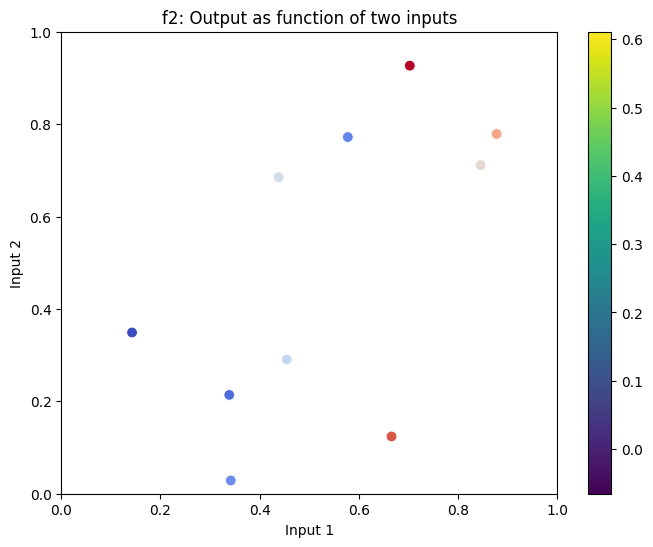

Evaluations: 10
Inputs shape: (10, 2)
Inputs range: [0.0287, 0.9266]
Performance range: [-0.0656, 0.6112]
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]


In [51]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")



Data is noisy.

We can try a RBF kernel combined with a WhiteKernel for noise in a Gaussian process regressor to consider that data is smooth as expected in a log likelihood.

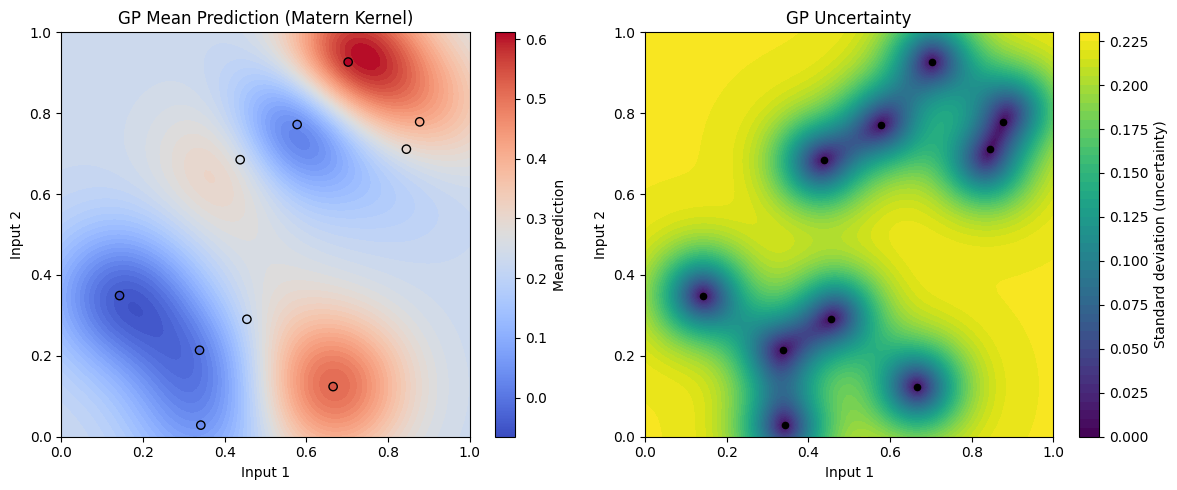

In [52]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

Let's use a UCB acquisition function, with a choice of k = 2.5.

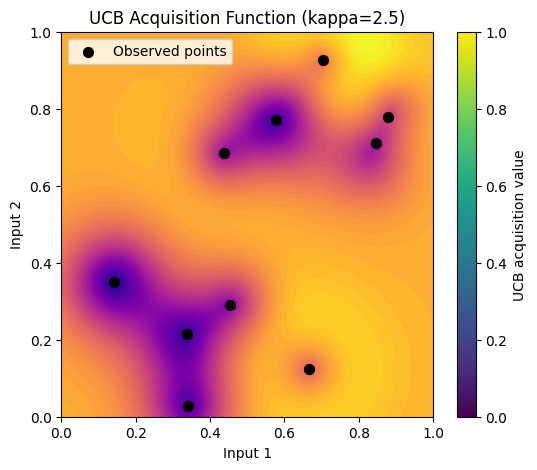

In [53]:
kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [54]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.81818182 0.97979798]
0.818182-0.979798


Submission for week 1: 0.818182-0.979798


### Week 2

In [55]:
#Load points to inputs and outputs from previous week
function = 2
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 0.6112
Last week's results: 0.1117


In [56]:
print(f"Correlation between inputs: {np.corrcoef(f2_inputs, rowvar=False)}")

print('Means:', f2_inputs.mean(axis=0))
print('Stds:', f2_inputs.std(axis=0))
print('Mins:', f2_inputs.min(axis=0))
print('Maxs:', f2_inputs.max(axis=0))
print('Std/Mean Ratios:', f2_inputs.std(axis=0) / (f2_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[1.         0.64729646]
 [0.64729646 1.        ]]
Means: [0.56393704 0.53264507]
Stds: [0.22911406 0.32234258]
Mins: [0.14269907 0.02869772]
Maxs: [0.87779099 0.979798  ]
Std/Mean Ratios: [0.40627596 0.60517331]


Let's try again a similar Gaussian process and plot the results with the new datapoint in hand.

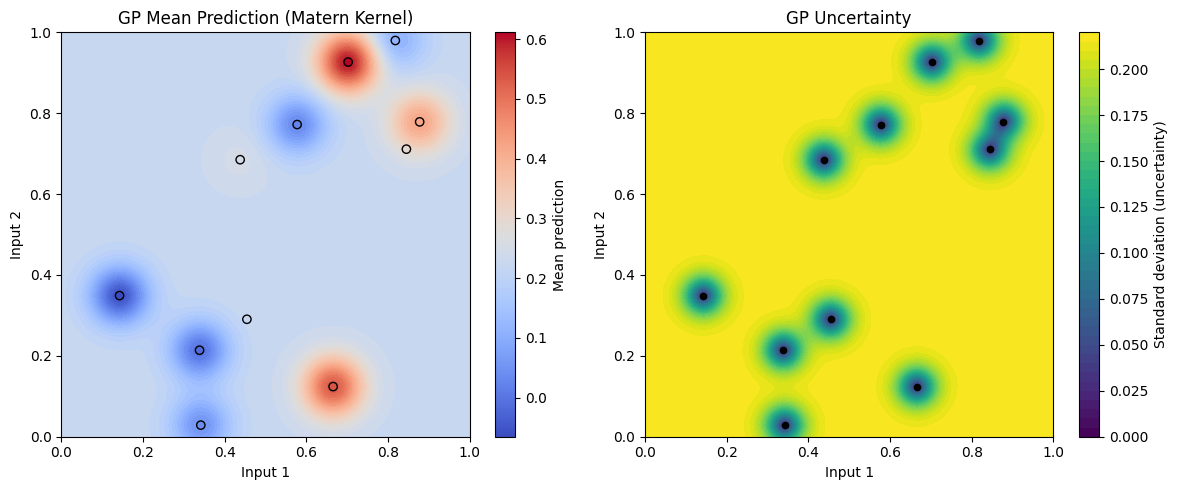

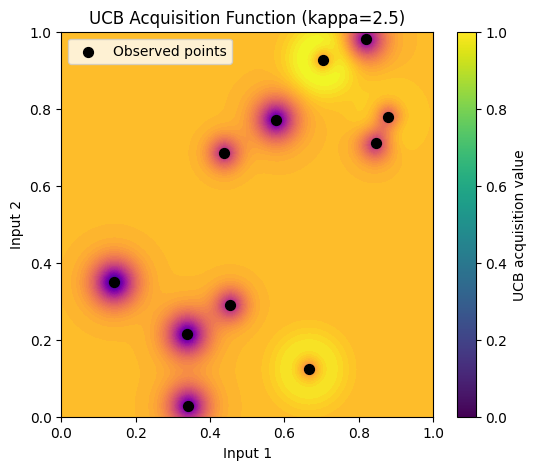

In [57]:
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-10,1)) + WhiteKernel(noise_level=1e-9, noise_level_bounds=(1e-12, 1e-3))
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 2.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

In [58]:
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)

Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.65656566 0.94949495]


The acquisition function is basically suggesting to sample around already known points that are close to the maximum. As we are still on week 2, it is worth to use exploration before exploiting the known areas, especially since we are told that it is easy to get stuck at a local minimum.

Let's try a different surrogate function with a penalized UCB for getting close to the borders.

1.05**2 * Matern(length_scale=[0.0516, 1.62], nu=2.5)
(10000, 2)


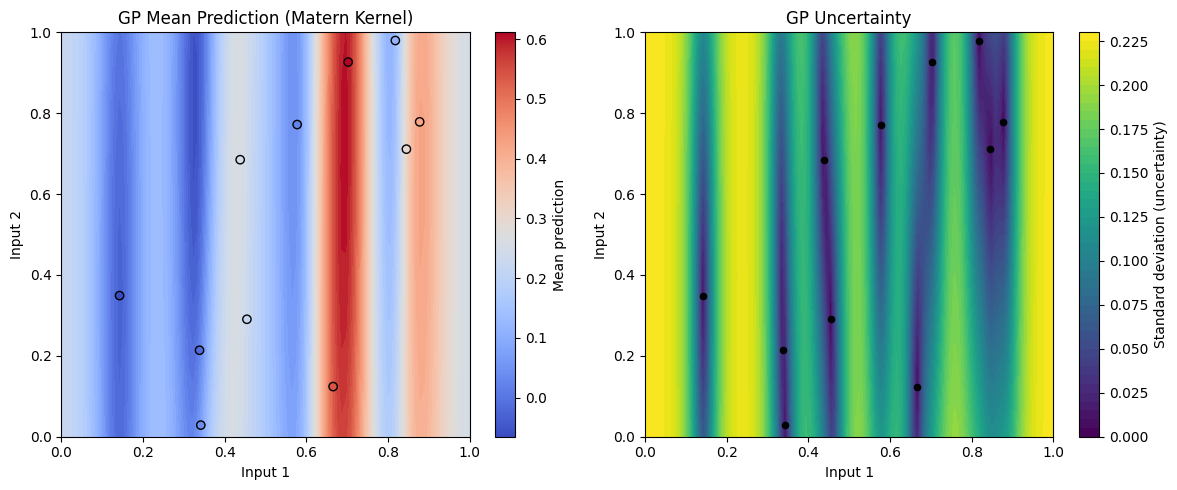

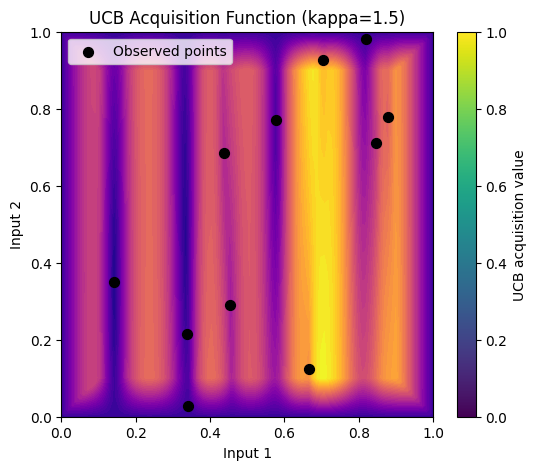

1.05**2 * Matern(length_scale=[0.0516, 1.62], nu=2.5)


In [59]:
kernel = C(1.0, (1e-2, 10.0)) * Matern(length_scale=[1.0, 1.0], length_scale_bounds=(0.01, 10.0), nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-8, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f2_inputs, f2_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

print(X_grid.shape)

y_mean, y_std = gp.predict(X_grid, return_std=True)
Y_mean = y_mean.reshape(X1.shape)
Y_std = y_std.reshape(X1.shape)

# Plot mean
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.contourf(X1, X2, Y_mean, cmap='coolwarm', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c=f2_outputs, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Mean prediction')
plt.title("GP Mean Prediction (Matern Kernel)")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

# Plot uncertainty
plt.subplot(1,2,2)
plt.contourf(X1, X2, Y_std, cmap='viridis', levels=50)
plt.colorbar(label='Standard deviation (uncertainty)')
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=20)
plt.title("GP Uncertainty")
plt.xlabel("Input 1")
plt.ylabel("Input 2")

plt.tight_layout()
plt.show()

kappa = 1.5
UCB = Y_mean + kappa * Y_std  # shape = (grid_size, grid_size)


# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_grid, axis=1), np.min(1 - X_grid, axis=1))

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB = UCB.reshape(100, 100)
penalty_factor = penalty_factor.reshape(100, 100)
UCB_penalized = UCB * penalty_factor

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, UCB_penalized, cmap='plasma', levels=50)
plt.scatter(f2_inputs[:,0], f2_inputs[:,1], c='k', s=50, label='Observed points')
plt.colorbar(label='UCB acquisition value')
plt.title(f"UCB Acquisition Function (kappa={kappa})")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

print(gp.kernel_)


In [60]:
max_idx = np.argmax(UCB_penalized)  # index of the maximum UCB
next_point = X_grid[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next point to sample based on UCB: [0.70707071 0.1010101 ]
0.707071-0.101010


Submission for week 2: 0.707071-0.101010

### Week 3

In [61]:
#Load points to inputs and outputs from previous week
function = 2
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6112
Last week's results: 0.5756
--
Inputs shape: (12, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.1121e-01]


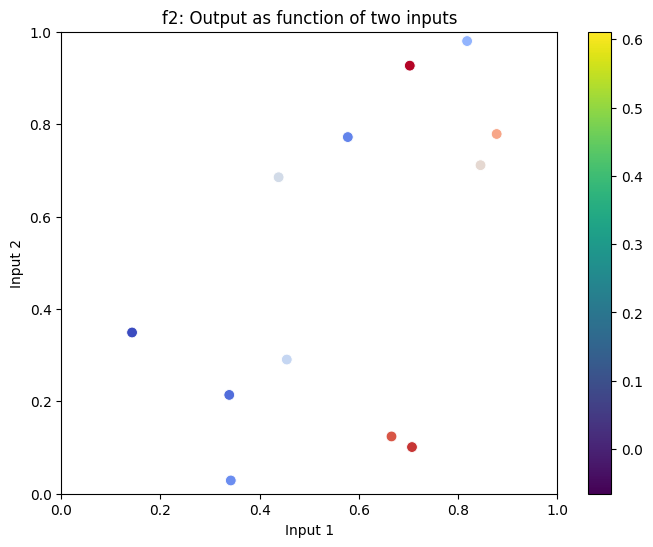

Evaluations: 12
Inputs shape: (12, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6112]
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]


In [62]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

Even though the performance did not improve this week, we found potential for another local maximum.

In [63]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.01**2 * Matern(length_scale=[0.0523, 2.56], nu=2.5)
Current best: 0.6112
Inputs producing current best: [0.70263656 0.9265642 ]
Next sample point (local optimizer): [0.69360468 0.80580796]
0.693605-0.805808


Submission for week 3: 0.693605-0.805808

Which is along the vertical line that we found to seem to contain maxima.

### Week 4

In [64]:
#Load points to inputs and outputs from previous week
function = 2
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? True
Current best: 0.6670
Last week's results: 0.6670
--
Inputs shape: (13, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


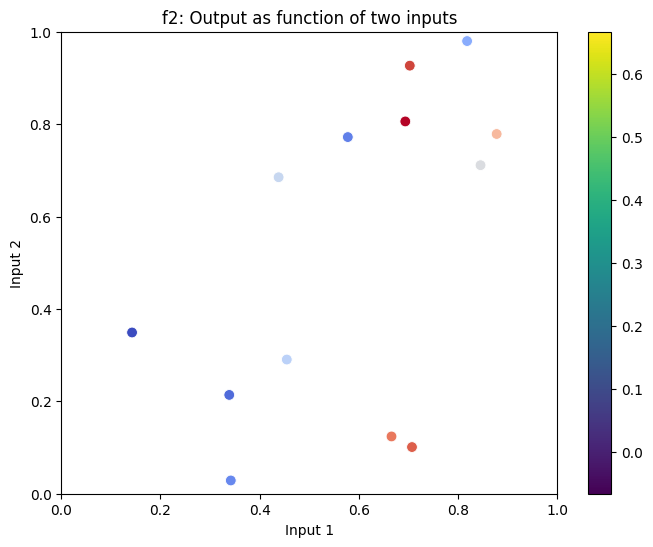

Evaluations: 13
Inputs shape: (13, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [65]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

This confirms that there is a vertical line along which the function evaluates to the highest values.

In [66]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.995**2 * Matern(length_scale=[0.0421, 1.35e+04], nu=2.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.68877185 0.84919565]
0.688772-0.849196


Submission for week 4: 0.688772-0.849196

### Week 5

In [67]:
#Load points to inputs and outputs from previous week
function = 2
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.5631
--
Inputs shape: (14, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


The description of the function tells us to keep exploring bayesian optimisation, so I will continue using surrogate Gaussian processes for this week with tweaked hyperparameters and still some exploration bias.

In [68]:
dims = 2

# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=1.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    #choosing kappa 1.5
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.899**2 * Matern(length_scale=[0.023, 4.78e+03], nu=1.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.69673825 0.30087831]
0.696738-0.300878


Submission for week 5: 0.696738-0.300878

### Week 6

In [69]:
#Load points to inputs and outputs from previous week
function = 2
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.6459
--
Inputs shape: (15, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


This is best than last week, and close to the currently known best, but not better than previous outputs.

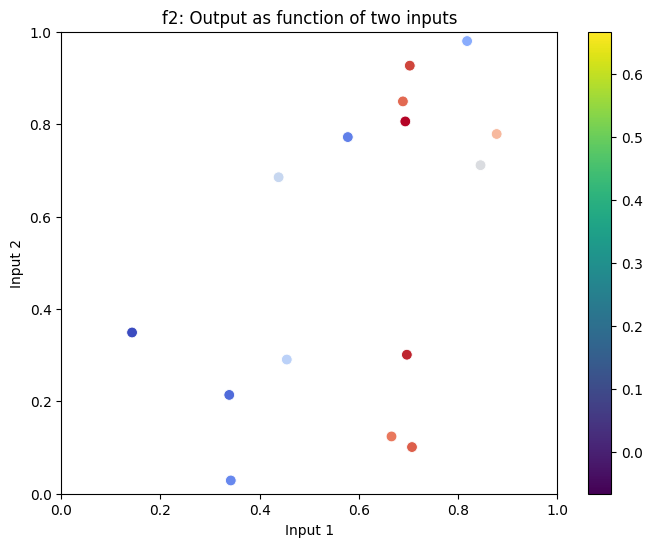

Evaluations: 15
Inputs shape: (15, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [70]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

There is clearly something along the vertial line at x1 = 0.7 that indicates maxima along that axis. The max values are in the 0.6-0.7 range.

Similar to what I have tried with function 1, I will just sample one random point manually. This is how I have decided to spend this week's "bullet".

In [71]:
chosen_point = np.array([0.9, 0.5])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.900000-0.500000


Sample for week 6: 0.900000-0.500000

### Week 7

In [72]:
#Load points to inputs and outputs from previous week
function = 2
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.1429
--
Inputs shape: (16, 2)
Inputs range: [0.0287, 0.9798]
Performance range: [-6.5624e-02, 6.6699e-01]


On week 6 we tried for the other functions to reuse whatever worked previously, with the hope that with the new available datapoints more improvement was found.

For this function, I have only found an improvement on week 3 so far, when a GP with an EI acquisition function was used. Let me use that again for this week's submission.

In [73]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.867**2 * Matern(length_scale=[0.0144, 18.1], nu=2.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.69447567 1.        ]
0.694476-1.000000


Submission for week 7: 0.694476-1.000000

### Week 8

In [74]:
#Load points to inputs and outputs from previous week
function = 2
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.6007
--
Inputs shape: (17, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.6699e-01]


Let us start using the TuRBO algorithm for this function as well. 

In [75]:
# Initializing the TuRBO state for f6
f2_turbo_state = TurboState(dim=2, best_value=np.max(f2_outputs), failure_tolerance=1, success_tolerance=2)
print(f"Trust Region Size: {f2_turbo_state.length}")

next_suggestion, f2_turbo_state = get_next_suggestion(f2_inputs, f2_outputs, f2_turbo_state)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on TuRBO: [0.443605 0.555808]
0.443605-0.555808


Submission for week 8: 0.443605-0.555808

### Week 9

In [76]:
#Load points to inputs and outputs from previous week
function = 2
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.1867
--
Inputs shape: (18, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.6699e-01]


Let us plot the function at this stage to get a better intuitive view of where we stand.

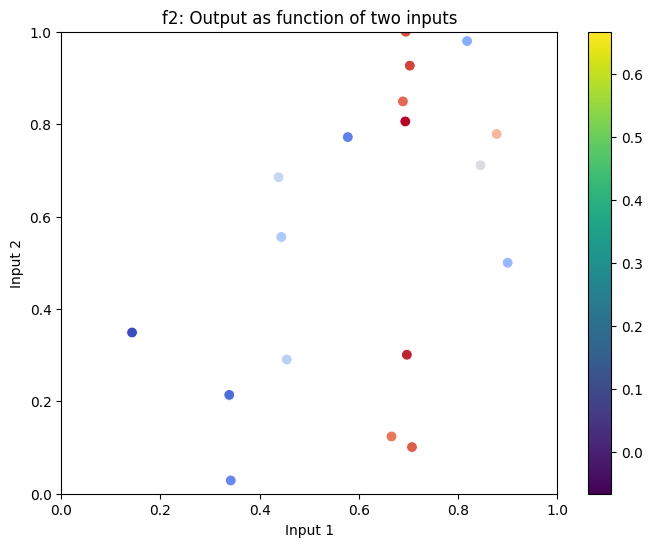

Evaluations: 18
Inputs shape: (18, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-0.0656, 0.6670]
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]


In [77]:
x1 = f2_inputs[:, 0]
x2 = f2_inputs[:, 1]
y = f2_outputs

# Put data into a DataFrame
df = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y": y
})

# Scatter plot with color encoding the output
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="coolwarm", s=60, legend=False)
plt.title("f2: Output as function of two inputs")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.xlim(0, 1)
plt.ylim(0, 1)
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()


print(f"Evaluations: {len(f2_inputs)}")
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4f}, {np.max(f2_outputs):.4f}]")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [78]:
old_length = f2_turbo_state.length
f2_turbo_state = update_state_from_history(f2_turbo_state, f2_outputs)
print(f"Trust Region Size: {f2_turbo_state.length} (Did we decay? {'Yes' if f2_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f2_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f2_outputs[-1].item())}")


next_suggestion, f2_turbo_state = get_next_suggestion(f2_inputs, f2_outputs, f2_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: 0.6669887774564723
Last output as interpreted by TuRBO: 0.1867419894922297
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on TuRBO: [0.70597013 0.6589217 ]
0.705970-0.658922


Submission for week 9: 0.700587-0.660921

### Week 10

In [79]:
#Load points to inputs and outputs from previous week
function = 2
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.5709
--
Inputs shape: (19, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.6699e-01]


Another round of the TuRBO algorithm with the same parameters. 

In [80]:
old_length = f2_turbo_state.length
f2_turbo_state = update_state_from_history(f2_turbo_state, f2_outputs)
print(f"Trust Region Size: {f2_turbo_state.length} (Did we decay? {'Yes' if f2_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f2_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f2_outputs[-1].item())}")


next_suggestion, f2_turbo_state = get_next_suggestion(f2_inputs, f2_outputs, f2_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: 0.6669887774564723
Last output as interpreted by TuRBO: 0.5709384710478032
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on TuRBO: [0.73004726 0.89864728]
0.730047-0.898647


Submission for week 10: 0.731990-0.886686

### Week 11

In [81]:
#Load points to inputs and outputs from previous week
function = 2
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.3391
--
Inputs shape: (20, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.6699e-01]


Another round of the TuRBO algorithm with the same parameters. 

In [82]:
old_length = f2_turbo_state.length
f2_turbo_state = update_state_from_history(f2_turbo_state, f2_outputs)
print(f"Trust Region Size: {f2_turbo_state.length} (Did we decay? {'Yes' if f2_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f2_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f2_outputs[-1].item())}")


next_suggestion, f2_turbo_state = get_next_suggestion(f2_inputs, f2_outputs, f2_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? Yes)
Best as known by the TuRBO state: 0.6669887774564723
Last output as interpreted by TuRBO: 0.33905127797063545
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next point to sample based on TuRBO: [0.66844987 0.73472148]
0.668450-0.734721


Submission for week 11: 0.668450-0.734721

### Week 12

In [83]:
#Load points to inputs and outputs from previous week
function = 2
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? False
Current best: 0.6670
Last week's results: 0.5473
--
Inputs shape: (21, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.6699e-01]


I only have two samples left, and for this function I have only made one improvement on week 3, when I used a Gaussian process implemented with sklearn (not Pytorch) with a Mattern Kernel with nu=2.5.

I will use that same methodology now that more samples have been gathered since through different methods, all with worse outputs.

I have observed at x = 0.7 a vertical line of high-output points.

In [84]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.889**2 * Matern(length_scale=[0.00962, 1.58], nu=2.5)
Current best: 0.6670
Inputs producing current best: [0.693605 0.805808]
Next sample point (local optimizer): [0.69293821 0.29801393]
0.692938-0.298014


Submission for week 12: 0.692938-0.298014

### Week 13

In [85]:
#Load points to inputs and outputs from previous week
function = 2
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f2_inputs = np.vstack([f2_inputs, row['provided_input'].values[0]])
f2_outputs = np.append(f2_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f2_inputs.shape}")
print(f"Inputs range: [{np.min(f2_inputs):.4f}, {np.max(f2_inputs):.4f}]")
print(f"Performance range: [{np.min(f2_outputs):.4e}, {np.max(f2_outputs):.4e}]")

Submission from last week improved something? True
Current best: 0.6982
Last week's results: 0.6982
--
Inputs shape: (22, 2)
Inputs range: [0.0287, 1.0000]
Performance range: [-6.5624e-02, 6.9822e-01]


I have found a new maximum, the best ever, by replicating this technique and it is as expected along x1 = 0.7.

For the final submission I will replicate this technique one last time, but maximizing the mean as acquisition function instead of an EI, because it is the final attempt.

In [ ]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f1_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 2)
    res = minimize(maximize_mean, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f2_outputs):.4f}")
print(f"Inputs producing current best: {f2_inputs[np.argmax(f2_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)

0.879**2 * Matern(length_scale=[0.0103, 1.52], nu=2.5)
Current best: 0.6982
Inputs producing current best: [0.692938 0.298014]
Next sample point (local optimizer): [0.69326474 0.42181067]
0.693265-0.421811


While I have observed, and the model has learned, that x=0.7 is the vertical axis of best results, this may be overfitting. 

As for the last submission of function 1, I will vary my strategy along these elements for the latest submission:
* Control the ``length_scale`` 
* Increase alpha to consider that the outputs are noisy
* Use mean maximization as acquisition function

In [267]:
# Define kernel: Matern with nu=1.5 (Matern) because it's slightly less 'perfectly smooth' than 2.5
# and with a a lower bound of length_scale to 0.05 to prevent overfitting, this may trigger warnings
kernel = C(1.0, (1e-2, 1e2)) * Matern(length_scale=[0.2, 0.2], 
                                     length_scale_bounds=(0.05, 0.5), 
                                     nu=1.5)
# Instantiate GP with a higher noise level
gp = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=0.05,        # Increased alpha to account for the 'noisy' description
    normalize_y=True, 
    n_restarts_optimizer=25,
    random_state=42
)

# Fit the GP model
gp.fit(f2_inputs, f2_outputs)
print(gp.kernel_)

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

bounds = [(0, 1), (0, 1)]
starts = np.vstack([
    np.random.uniform(0, 1, (100, 2)),
    f2_inputs[np.argsort(f2_outputs)[-5:]] # start near the top 5 known best points
])
num_restarts = 1500 
results = []
np.random.seed(42)

for x0 in starts:
    res = minimize(maximize_mean, x0, bounds=bounds, method='L-BFGS-B')
    if res.success:
        results.append(res)

# Select best solution
best_res = min(results, key=lambda r: r.fun)
next_point = best_res.x

print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 0.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.878**2 * Matern(length_scale=[0.05, 0.5], nu=1.5)
Next sample point (local optimizer): [0.69093705 0.31493908]
0.690937-0.314939


Final submission for week 13: 0.690937-0.314939

## Function 3

This function is a function with a 1D output and a 3D input. 

This is the description of the function: you’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

### Week 1

Let's observe the data.

In [87]:
#print(f3_inputs)
#print(f3_outputs)

print(f"Evaluations: {len(f3_inputs)}")
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")


Evaluations: 15
Inputs shape: (15, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]


And even attempt to plot it.

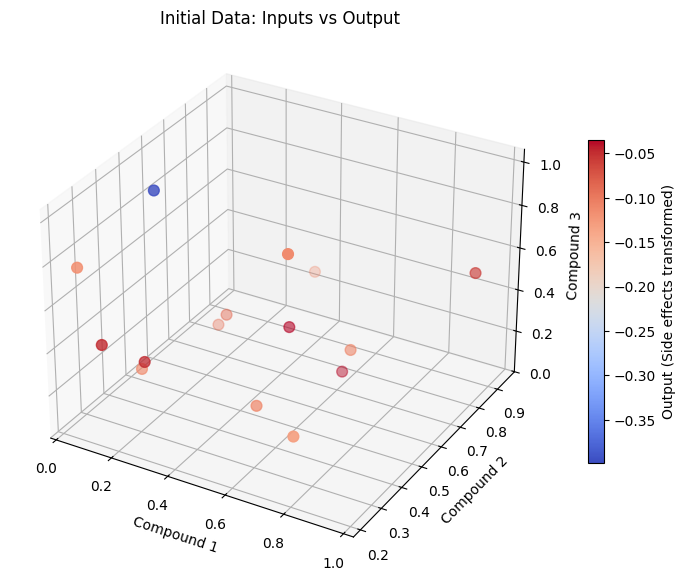

In [88]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(f3_inputs[:,0], f3_inputs[:,1], f3_inputs[:,2], 
                c=f3_outputs, cmap='coolwarm', s=60)

ax.set_xlabel("Compound 1")
ax.set_ylabel("Compound 2")
ax.set_zlabel("Compound 3")
ax.set_title("Initial Data: Inputs vs Output")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Output (Side effects transformed)")
plt.show()

In [89]:
# Let's follow a similar approach as with the others with a Matern and WhiteKerel

kernel = Matern(length_scale=[0.1, 0.1, 0.1], length_scale_bounds=(0.01, 1.0), nu=1.5) \
         + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=10)
gp.fit(f3_inputs, f3_outputs)

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,Matern(length...e_level=1e-06)
,alpha,1e-06
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,"Matern(length... 0.1], nu=1.5)"
,kernel__k2,WhiteKernel(noise_level=1e-06)
,kernel__k1__length_scale,"[0.1, 0.1, ...]"


Getting these warnings:
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
* ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

In [90]:
# Trying new hyperparameters, with wider length scale bounds, and introducing noise_level_bounds. amd more restarts optimizers, a constant kernel and wider bounds.

# Let's follow a similar approach as with the others with a Matern and WhiteKerel and a Constant Kernel (because I was getting many "close to bounds" messages)

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.17241379 0.20689655 0.24137931]
0.172414-0.206897-0.241379


Submission for week 1: 0.172414-0.206897-0.206897

### Week 2

In [91]:
#Load points to inputs and outputs from previous week
function = 3
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1476


In [92]:
print(f"Correlation between inputs: {np.corrcoef(f3_inputs, rowvar=False)}")

print('Means:', f3_inputs.mean(axis=0))
print('Stds:', f3_inputs.std(axis=0))
print('Mins:', f3_inputs.min(axis=0))
print('Maxs:', f3_inputs.max(axis=0))
print('Std/Mean Ratios:', f3_inputs.std(axis=0) / (f3_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: [[ 1.          0.43437673 -0.08996019]
 [ 0.43437673  1.         -0.22739406]
 [-0.08996019 -0.22739406  1.        ]]
Means: [0.39424239 0.49825298 0.3905444 ]
Stds: [0.26357423 0.23052493 0.26998681]
Mins: [0.04680895 0.206897   0.06608864]
Maxs: [0.96599485 0.94135983 0.99088187]
Std/Mean Ratios: [0.66855884 0.46266644 0.6913089 ]


Let us try the same strategy again but with a UCB function

In [93]:
kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
gp.fit(f3_inputs, f3_outputs)


print(gp.kernel_)
#print(f3_inputs)

# And calculate over the whole cube

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on PI:", next_point_pi)

kappa = 0.5
UCB = y_mean + kappa * y_std  # shape = (grid_size, grid_size)
max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point_ucb = X_candidate[max_idx]  # coordinates in input space
print("Next point to sample based on UCB:", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

1.06**2 * Matern(length_scale=[0.00375, 1.59e+07, 2.7e+04], nu=2.5) + WhiteKernel(noise_level=0.00456)
Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next point to sample based on PI: [0.13793103 0.10344828 0.4137931 ]
Next point to sample based on UCB: [0.13793103 0.         0.4137931 ]
0.137931-0.000000-0.413793


Submission for week 2: 0.862069-0.137931-0.655172

### Week 3

In [94]:
#Load points to inputs and outputs from previous week
function = 3
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1406
--
Inputs shape: (17, 3)
Inputs range: [0.0468, 0.9909]
Performance range: [-0.3989, -0.0348]


For this function I have been unable to make any improvement yet. This week I will try the same approach as for functions 1 and 2 with an EI acquisition function.

In [95]:
# Define kernel: Matern with nu=2.5 for sharp peaks
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*3, nu=2.5)

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1), (0, 1), (0, 1)]
num_restarts = 1500 # I have incremented this until the estimation did no longer move (fixed random seed)
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 3)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.19**2 * Matern(length_scale=[1e+05, 2.5e+04, 0.0299], nu=2.5)


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best: -0.0348
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next sample point (local optimizer): [0.50746773 0.00638587 0.30476654]
0.507468-0.006386-0.304767


Submission for week 3: 0.507468-0.006386-0.305268

### Week 4

In [96]:
#Load points to inputs and outputs from previous week
function = 3
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0348
Last week's results: -0.1297
--
Inputs shape: (18, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0348]


I have yet to be able to further optimize this function beyond the known best values.

I will try an RBF kernel despite the description of sharp peaks.

In [97]:
dims = 3

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

1.83**2 * RBF(length_scale=[1, 0.93, 0.15])


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best: -3.4835e-02
Inputs producing current best: [0.49258141 0.61159319 0.34017639]
Next sample point (ei): [1.         0.60328737 0.83528216]
Next sample point (ucb): [1.         1.         0.81556324]
1.000000-0.603287-0.835282


I choose the EI value.

Submission for week 4: 0.589937-0.603952-0.435945

### Week 5

In [98]:
#Load points to inputs and outputs from previous week
function = 3
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.0015
Last week's results: -0.0015
--
Inputs shape: (19, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0015]


This is a near 0 value! Remember that 0 is the goal. This week's submission should be focused on exploitation of this area. Last week we chose the highest EI, let's replicate the same again.

In [99]:
dims = 3

#kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,10))
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*dims, nu=1.5) + C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
# Instantiate GP with small noise level
#gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-12)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 0.4), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print("Next sample point (pi):", next_point_pi)


print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

1.05**2 * Matern(length_scale=[0.00415, 1.06e+07, 139], nu=2.5) + WhiteKernel(noise_level=0.00824)
Current best: -1.4942e-03
Inputs producing current best: [0.589937 0.603952 0.435945]
Next sample point (ei): [0.59311412 0.44844552 0.29321078]
Next sample point (ucb): [0.59125107 0.47157619 0.41184091]
Next sample point (pi): [0.59183673 0.44897959 0.3877551 ]
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
0.593114-0.448446-0.293211


Submission for week 5: 0.593114-0.448446-0.293211

### Week 6

In [100]:
#Load points to inputs and outputs from previous week
function = 3
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.0753
--
Inputs shape: (20, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0015]


I will try again the same strategy as we are very close to 0. EI as aquisition function.

In [101]:
dims = 3

#kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,10))
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*dims, nu=1.5) + C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-5, 1e8), nu=2.5) \
         + WhiteKernel(noise_level=1e-8, noise_level_bounds=(1e-10, 1e0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=20, random_state=42)
# Instantiate GP with small noise level
#gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-12)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 250
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 0.4), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# We will use Probability of improvement (PI) as an acquisition function with a penalty for being close to the boundary (was getting 1 1 0)
y_max = np.max(f3_outputs)
eta = 0.01
z = (y_mean - y_max - eta) / (y_std + 1e-12)
pi = stats.norm.cdf(z)
boundary_distances = np.minimum(X_candidate, 1 - X_candidate)
min_boundary_distance = np.min(boundary_distances, axis=1)
boundary_penalty = np.clip(min_boundary_distance / 0.1, 0, 1)
        
acquisition_function = pi * boundary_penalty

best_idx = np.argmax(acquisition_function)
next_point_pi = X_candidate[best_idx]

print("Next sample point (pi):", next_point_pi)


print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.05**2 * Matern(length_scale=[0.0034, 1e+08, 2.5e+04], nu=2.5) + WhiteKernel(noise_level=0.00394)
Current best: -1.4942e-03
Inputs producing current best: [0.589937 0.603952 0.435945]
Next sample point (ei): [0.5878696  0.09717649 0.61500723]
Next sample point (ucb): [0.58889535 0.77096718 0.4937956 ]
Next sample point (pi): [0.48979592 0.10204082 0.89795918]
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
0.587870-0.097176-0.615007


Submission for week 6: 0.587870-0.097176-0.615007

### Week 7

In [102]:
#Load points to inputs and outputs from previous week
function = 3
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.1211
--
Inputs shape: (21, 3)
Inputs range: [0.0064, 0.9909]
Performance range: [-0.3989, -0.0015]


On week 6 we tried for the other functions to reuse whatever worked previously, with the hope that with the new available datapoints more improvement was found.

For this function, I have only found an improvement on week 4 so far, when a GP with an RBF kernel with an EI acquisition function was used. Let me use that again for this week's submission. Interestingly enough, with the parameters used that week, both EI and UCB suggest nearby sample points.

In [103]:
dims = 3

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.2]*dims, length_scale_bounds=(1e-10,1))

# Instantiate GP with small noise level
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True)

# Fit the GP model
gp.fit(f3_inputs, f3_outputs)
print(gp.kernel_)


# Function to optimize acquisition: Expected Improvement
def acquisitionf(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f3_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  

# Robust acquisition maximization via multi-start local optimization
bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    res = minimize(acquisitionf, x0, bounds=bounds, method='L-BFGS-B')
    results.append(res)

print(f"Current best: {np.max(f3_outputs):.4e}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")

# Select best solution from restarts
next_point_ei = min(results, key=lambda r: r.fun).x
print("Next sample point (ei):", next_point_ei)


def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 1.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (ucb):", next_point_ucb)


print("-".join(f"{x:.6f}" for x in next_point_ei.flatten()))

1.75**2 * RBF(length_scale=[0.817, 0.862, 0.162])
Current best: -1.4942e-03
Inputs producing current best: [0.589937 0.603952 0.435945]
Next sample point (ei): [1.         1.         0.84508765]
Next sample point (ucb): [1.         1.         0.84046247]
1.000000-1.000000-0.845088


Submission for week 7: 1.000000-1.000000-0.845088

### Week 8

In [104]:
#Load points to inputs and outputs from previous week
function = 3
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.0719
--
Inputs shape: (22, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0015]


Let us start using the TuRBO algorithm for this function as well. 

In [105]:
# Initializing the TuRBO state for f6
f3_turbo_state = TurboState(dim=3, best_value=np.max(f3_outputs), failure_tolerance=1, success_tolerance=2)
print(f"Trust Region Size: {f3_turbo_state.length}")

next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state)

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
Next point to sample based on TuRBO: [0.339937 0.353952 0.185945]
0.339937-0.353952-0.185945


Submission for week 8: 0.839937-0.853952-0.685945

### Week 9

In [106]:
#Load points to inputs and outputs from previous week
function = 3
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.1431
--
Inputs shape: (23, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0015]


Because the input vectors are 3D, let us take some time to develop some graphical instuition of what is going on:

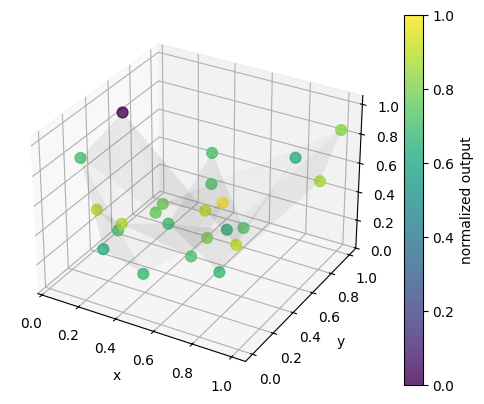

In [107]:
from matplotlib.tri import Triangulation

# ---- inputs ----
# f3_inputs: shape (N, 3), values in [0, 1]
# f3_outputs: shape (N,) or (N, 1)

X = f3_inputs[:, 0]
Y = f3_inputs[:, 1]
Z = f3_inputs[:, 2]
values = f3_outputs.squeeze()

# ---- normalize outputs ----
values_norm = (values - values.min()) / (values.max() - values.min())

# ---- scatter plot ----
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(
    X, Y, Z,
    c=values_norm,
    s=60,          # clutter reduction
    alpha=0.8
)

plt.colorbar(sc, ax=ax, label='normalized output')

# ---- interpolated surface (very faint) ----
tri = Triangulation(X, Y)

ax.plot_trisurf(
    tri,
    Z,
    color='gray',
    alpha=0.05,    # almost invisible
    linewidth=0,
    antialiased=True
)

# ---- labels ----
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()


Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [108]:
old_length = f3_turbo_state.length
f3_turbo_state = update_state_from_history(f3_turbo_state, f3_outputs)
print(f"Trust Region Size: {f3_turbo_state.length} (Did we decay? {'Yes' if f3_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f3_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f3_outputs[-1].item())}")


next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: -0.0014942495830570148
Last output as interpreted by TuRBO: -0.14305645069225134
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
Next point to sample based on TuRBO: [0.51935134 0.76901884 0.47898499]
0.519351-0.769019-0.478985


Submission for week 9: 0.450444-0.724011-0.451608

### Week 10

In [109]:
#Load points to inputs and outputs from previous week
function = 3
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.0132
--
Inputs shape: (24, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0015]


Another round of the TuRBO algorithm with the same parameters as the previous round.

In [110]:
old_length = f3_turbo_state.length
f3_turbo_state = update_state_from_history(f3_turbo_state, f3_outputs)
print(f"Trust Region Size: {f3_turbo_state.length} (Did we decay? {'Yes' if f3_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f3_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f3_outputs[-1].item())}")


next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: -0.0014942495830570148
Last output as interpreted by TuRBO: -0.013248403900766762
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
Next point to sample based on TuRBO: [0.68520737 0.71109761 0.43265183]
0.685207-0.711098-0.432652


Submission for week 10: 0.696321-0.705583-0.454502

### Week 11

In [111]:
#Load points to inputs and outputs from previous week
function = 3
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0015
Last week's results: -0.0394
--
Inputs shape: (25, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0015]


Another round of the TuRBO algorithm with the same parameters as the previous round.

In [112]:
old_length = f3_turbo_state.length
f3_turbo_state = update_state_from_history(f3_turbo_state, f3_outputs)
print(f"Trust Region Size: {f3_turbo_state.length} (Did we decay? {'Yes' if f3_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f3_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f3_outputs[-1].item())}")


next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? Yes)
Best as known by the TuRBO state: -0.0014942495830570148
Last output as interpreted by TuRBO: -0.039422584421534436
Current best: -0.0015
Inputs producing current best: [0.589937 0.603952 0.435945]
Next point to sample based on TuRBO: [0.51727854 0.54446954 0.43243572]
0.517279-0.544470-0.432436


Submission for week 11: 0.517279-0.544470-0.432436

### Week 12

In [113]:
#Load points to inputs and outputs from previous week
function = 3
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.0012
Last week's results: -0.0012
--
Inputs shape: (26, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0012]


For this second last week, given last week's performance, I will try yet another round of the TuRBO algorithm with the same parameters.

In [114]:
old_length = f3_turbo_state.length
f3_turbo_state = update_state_from_history(f3_turbo_state, f3_outputs)
print(f"Trust Region Size: {f3_turbo_state.length} (Did we decay? {'Yes' if f3_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f3_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f3_outputs[-1].item())}")


next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.09876543209876543 (Did we decay? Yes)
Best as known by the TuRBO state: -0.0012436765147074646
Last output as interpreted by TuRBO: -0.0012436765147074646
Current best: -0.0012
Inputs producing current best: [0.517279 0.54447  0.432436]
Next point to sample based on TuRBO: [0.47196043 0.502261   0.41424065]
0.471960-0.502261-0.414241


Submission for week 12: 0.471960-0.502261-0.414241

### Week 13

In [268]:
#Load points to inputs and outputs from previous week
function = 3
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f3_inputs = np.vstack([f3_inputs, row['provided_input'].values[0]])
f3_outputs = np.append(f3_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f3_inputs.shape}")
print(f"Inputs range: [{np.min(f3_inputs):.4f}, {np.max(f3_inputs):.4f}]")
print(f"Performance range: [{np.min(f3_outputs):.4f}, {np.max(f3_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.0012
Last week's results: -0.0063
--
Inputs shape: (27, 3)
Inputs range: [0.0064, 1.0000]
Performance range: [-0.3989, -0.0012]


Things did not improved this week, but for a final submission, I will try the TuRBO algorithm once again, in particular because it will further reduce the confidence region, which is what I need for a last attempt.

In [269]:
old_length = f3_turbo_state.length
f3_turbo_state = update_state_from_history(f3_turbo_state, f3_outputs)
print(f"Trust Region Size: {f3_turbo_state.length} (Did we decay? {'Yes' if f3_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f3_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f3_outputs[-1].item())}")


next_suggestion, f3_turbo_state = get_next_suggestion(f3_inputs, f3_outputs, f3_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f3_outputs):.4f}")
print(f"Inputs producing current best: {f3_inputs[np.argmax(f3_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.06584362139917695 (Did we decay? Yes)
Best as known by the TuRBO state: -0.0012436765147074646
Last output as interpreted by TuRBO: -0.0063272671803870665
Current best: -0.0012
Inputs producing current best: [0.517279 0.54447  0.432436]
Next point to sample based on TuRBO: [0.51619665 0.51875895 0.46144556]
0.516197-0.518759-0.461446


Final submission for week 13: 0.516197-0.518759-0.461446

## Function 4

This function is a function with a 1D output and a 4D input. 

This is the description of the function: Address the challenge of optimally placing products across warehouses for a business with high online sales, where accurate calculations are costly and only feasible biweekly. To speed up decision-making, an ML model approximates these results within hours. The model has four hyperparameters to tune, and its output reflects the difference from the expensive baseline. Because the system is dynamic and full of local optima, it requires careful tuning and robust validation to find reliable, near-optimal solutions. 

### Week 1

It is no longer viable to plot anything, so let's just look at the data:

In [115]:
print(f"Evaluations: {len(f4_inputs)}")
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")


Evaluations: 30
Inputs shape: (30, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, -4.0255]
Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]


In [116]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)
ei

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -4.0255
Inputs producing current best: [0.57776561 0.42877174 0.42582587 0.24900741]
Next point to sample based on PI: [0.44827586 0.4137931  0.37931034 0.37931034]
0.448276-0.413793-0.379310-0.379310


Submission for week 1: 0.448276-0.413793-0.379310-0.379310

### Week 2

In [117]:
#Load points to inputs and outputs from previous week
function = 4
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: -0.0512
Previous best: -4.0255
Last week's results: -0.0512


This yielded a very good improvement. Let's replicate the method again this week, including the EI function.

In [118]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

3.18**2 * Matern(length_scale=[1.56, 1.46, 1.58, 1.43], nu=2.5) + WhiteKernel(noise_level=7.76e-15)
Current best: -0.0512
Inputs producing current best: [0.448276 0.413793 0.37931  0.37931 ]
Next point to sample based on PI: [0.4137931  0.4137931  0.34482759 0.4137931 ]
0.413793-0.413793-0.344828-0.413793


The kernel is very balanced in terms of length scale for each dimension.

Submission for week 2: 0.413793-0.413793-0.344828-0.413793

### Week 3

In [119]:
#Load points to inputs and outputs from previous week
function = 4
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? True
Current best: 0.6231
Last week's results: 0.6231
--
Inputs shape: (32, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, 0.6231]


While this is the second improvement in a row, this function 4 has been sampled around the same point for two weeks in a row already.  This is encouraging exploitation. This week, for a change, I am using a UCB kernel encouraging exploration to see if I can find another local minimum.

In [120]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 3.7 to encourage exploration
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 3.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


3.03**2 * Matern(length_scale=[1.57, 1.38, 1.64, 1.42], nu=2.5) + WhiteKernel(noise_level=0.000247)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (local optimizer): [0.47186128 0.44620017 0.13676784 0.43451091]
0.471861-0.446200-0.136768-0.434511


Submission for week 3: 0.471861-0.446201-0.136768-0.434511

This is still exploiting this area. Next week I will just sample the point furthest from all known samples.

### Week 4

In [121]:
#Load points to inputs and outputs from previous week
function = 4
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -5.2800
--
Inputs shape: (33, 4)
Inputs range: [0.0063, 0.9995]
Performance range: [-32.6257, 0.6231]


This week the goal is just to sample the point that is further away from all known points to try and find another local minimum as the function descriptions describes it as having many and my strategy so far has been on exploitation.

In [122]:
# Function to compute the minimum distance from a given point to the set of known points
def min_distance_to_points(point, points):
    # Compute pairwise distances between the point and each of the known points
    distances = cdist([point], points)
    # Return the minimum distance (further away from the closest point)
    return np.min(distances)

# Objective function to maximize the minimum distance
def objective_function(point, points):
    # We want to maximize the minimum distance, so we return the negative of the minimum distance
    return -min_distance_to_points(point, points)

# Bounds for the variables (each dimension is within [0,1])
bounds = [(0, 1)] * 4
num_restarts = 150
results = []
# Initial guess (can be any point in the space, e.g., the center of the space)
np.random.seed(42)
initial_guess = np.random.uniform(0, 1, 4)

for _ in range(num_restarts):
    res = minimize(objective_function, initial_guess, args=(f4_inputs,), bounds=bounds, method='L-BFGS-B')
    results.append(res)

# The resulting point is the one furthest from all known points
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (furthest point from known data):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (furthest point from known data): [0.57193085 1.         1.         0.        ]
0.571931-1.000000-1.000000-0.000000


This is clearly one corner that I am choosing to explore.

Submission for week 4: 0.571931-1.000000-1.000000-0.000000

### Week 5

In [123]:
#Load points to inputs and outputs from previous week
function = 4
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -36.7685
--
Inputs shape: (34, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6231]


In [124]:
f4_inputs_outputs = np.hstack([f4_inputs, f4_outputs.reshape(f4_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f4_inputs_outputs, rowvar=False)}")


Correlation between inputs and with outputs (last column): 
[[ 1.          0.24865683  0.25104458  0.18123066 -0.46836549]
 [ 0.24865683  1.          0.0425613   0.09155326 -0.49608928]
 [ 0.25104458  0.0425613   1.         -0.22290882 -0.28641173]
 [ 0.18123066  0.09155326 -0.22290882  1.         -0.30544031]
 [-0.46836549 -0.49608928 -0.28641173 -0.30544031  1.        ]]


There is a negative correlation between all the inputs and the outputs.

Let's remember that this function is full of local optima. Because we are still in week 5, we can affort to explore a bit more.

I will try a dimensionality-reduction technique to plot and visualize what we`ve got so far.

In [125]:
pca = PCA(n_components = 3)
f4_inputs_3d = pca.fit_transform(f4_inputs)

print(pca.explained_variance_ratio_)

[0.35518956 0.29370292 0.22081233]


So three dimentions explain about 0.35 + 0.30 + 0.22 = 0.87 of the variance. 

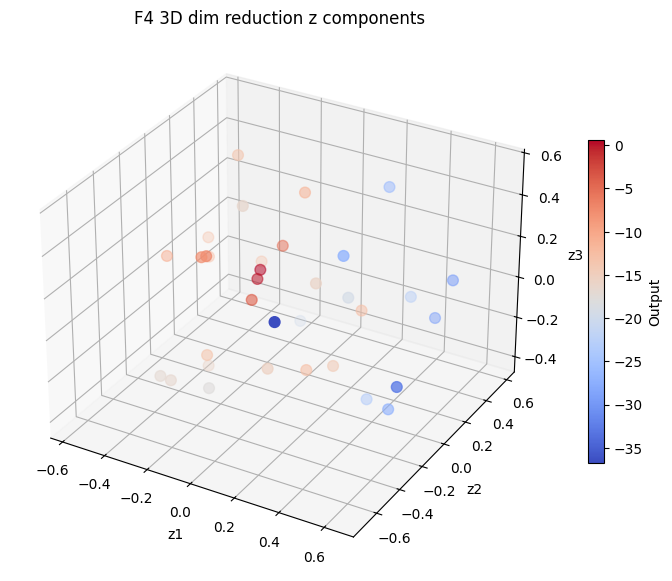

In [126]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(f4_inputs_3d[:,0], f4_inputs_3d[:,1], f4_inputs_3d[:,2], 
                c=f4_outputs, cmap='coolwarm', s=60)

ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
ax.set_title("F4 3D dim reduction z components")
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Output")
plt.show()

No local minima are observed but rather a cluster of values close to the maximum. 

I wanted to explore using a neural network this week, but given the results I think there is still some value in using a Gaussian process as a surrogate function once again considering the new extreme data point from last week.

Let's first explore where the furthest point lies now.

In [127]:
num_restarts = 250

for _ in range(num_restarts):
    res = minimize(objective_function, initial_guess, args=(f4_inputs,), bounds=bounds, method='L-BFGS-B')
    results.append(res)

# The resulting point is the one furthest from all known points
next_point = min(results, key=lambda r: r.fun).x

print("Current furthest point from known data:", next_point)

Current furthest point from known data: [0.57193085 1.         1.         0.        ]


No need to explore another corner. Let's use a GP with a Matern kernel and a softer nu. Still UCB, with a heavily exploratory kappa parameter.

In [128]:
dims = 4

kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*dims, length_scale_bounds=(0.1, 1000.0), nu=1.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(dims)]
num_restarts = 50 
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, dims)
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
                 args=(gp, 3.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

4.6**2 * Matern(length_scale=[3.57, 3.14, 3.2, 3.31], nu=1.5) + WhiteKernel(noise_level=0.000542)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next sample point (local optimizer): [0.3056165  0.43474574 0.45680304 0.47334119]
0.305616-0.434746-0.456803-0.473341


Submission for week 5: 0.305616-0.434746-0.456803-0.473341

### Week 6

In [129]:
#Load points to inputs and outputs from previous week
function = 4
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6231
Last week's results: -1.9817
--
Inputs shape: (35, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6231]


Last week's results were far from an improvement, actually improvement was found only on the first 2 weeks, so let us focus on what was done then and try to exploit around that point.

In [130]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.73**2 * Matern(length_scale=[1.52, 1.54, 1.43, 1.5], nu=2.5) + WhiteKernel(noise_level=0.00273)
Current best: 0.6231
Inputs producing current best: [0.413793 0.413793 0.344828 0.413793]
Next point to sample based on PI: [0.4137931  0.4137931  0.37931034 0.4137931 ]
0.413793-0.413793-0.379310-0.413793


Submission for week 6: 0.413793-0.413793-0.379310-0.413793

### Week 7

In [131]:
#Load points to inputs and outputs from previous week
function = 4
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? True
Current best: 0.6402
Last week's results: 0.6402
--
Inputs shape: (36, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


In [132]:
# Initializing the TuRBO state for f6
f4_turbo_state = TurboState(dim=4, best_value=np.max(f4_outputs), failure_tolerance=1, success_tolerance=2)

print(f"Trust Region Size: {f4_turbo_state.length}")
print(f"Best as known by the TuRBO state: {f4_turbo_state.best_value}")


next_suggestion, f4_turbo_state = get_next_suggestion(f4_inputs, f4_outputs, f4_turbo_state)

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"# inputs: {len(f4_inputs)}, # outputs: {len(f4_outputs)}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Best as known by the TuRBO state: 0.640155190044084
Current best: 0.6402
# inputs: 36, # outputs: 36
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on TuRBO: [0.663793 0.663793 0.62931  0.663793]
0.663793-0.663793-0.629310-0.663793


Submission for week 7: 0.163793-0.163793-0.129310-0.163793

### Week 8

In [133]:
#Load points to inputs and outputs from previous week
function = 4
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6402
Last week's results: -11.4017
--
Inputs shape: (37, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


Another round of the TuRBO algorithm.

In [134]:
old_length = f4_turbo_state.length
f4_turbo_state = update_state_from_history(f4_turbo_state, f4_outputs)
print(f"Trust Region Size: {f4_turbo_state.length} (Did we decay? {'Yes' if f4_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f4_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f4_outputs[-1].item())}")


next_suggestion, f4_turbo_state = get_next_suggestion(f4_inputs, f4_outputs, f4_turbo_state)

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: 0.640155190044084
Last output as interpreted by TuRBO: -11.401661511279425
Current best: 0.6402
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on TuRBO: [0.24712633 0.24712633 0.21264333 0.24712633]
0.247126-0.247126-0.212643-0.247126


Submission for week 8: 0.247126-0.247126-0.212643-0.247126

### Week 9

In [135]:
#Load points to inputs and outputs from previous week
function = 4
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6402
Last week's results: -5.8397
--
Inputs shape: (38, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [136]:
old_length = f4_turbo_state.length
f4_turbo_state = update_state_from_history(f4_turbo_state, f4_outputs)
print(f"Trust Region Size: {f4_turbo_state.length} (Did we decay? {'Yes' if f4_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f4_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f4_outputs[-1].item())}")


next_suggestion, f4_turbo_state = get_next_suggestion(f4_inputs, f4_outputs, f4_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: 0.640155190044084
Last output as interpreted by TuRBO: -5.8397270374836765
Current best: 0.6402
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on TuRBO: [0.40993964 0.3287995  0.37382747 0.45183409]
0.409940-0.328799-0.373827-0.451834


Submission for week 9: 0.410905-0.365022-0.396181-0.416967

### Week 10

In [137]:
#Load points to inputs and outputs from previous week
function = 4
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6402
Last week's results: 0.6146
--
Inputs shape: (39, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


Another round of the TuRBO algorithm with the same parameters as last week.

In [138]:
old_length = f4_turbo_state.length
f4_turbo_state = update_state_from_history(f4_turbo_state, f4_outputs)
print(f"Trust Region Size: {f4_turbo_state.length} (Did we decay? {'Yes' if f4_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f4_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f4_outputs[-1].item())}")


next_suggestion, f4_turbo_state = get_next_suggestion(f4_inputs, f4_outputs, f4_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? Yes)
Best as known by the TuRBO state: 0.640155190044084
Last output as interpreted by TuRBO: 0.6146454731570015
Current best: 0.6402
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on TuRBO: [0.44598858 0.36760954 0.37031551 0.46837983]
0.445989-0.367610-0.370316-0.468380


Submission for week 10: 0.439447-0.365834-0.381055-0.465766

### Week 11

In [139]:
#Load points to inputs and outputs from previous week
function = 4
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6402
Last week's results: -0.6621
--
Inputs shape: (40, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


Another round of the TuRBO algorithm with the same parameters as last week.

In [140]:
old_length = f4_turbo_state.length
f4_turbo_state = update_state_from_history(f4_turbo_state, f4_outputs)
print(f"Trust Region Size: {f4_turbo_state.length} (Did we decay? {'Yes' if f4_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f4_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f4_outputs[-1].item())}")


next_suggestion, f4_turbo_state = get_next_suggestion(f4_inputs, f4_outputs, f4_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.09876543209876543 (Did we decay? Yes)
Best as known by the TuRBO state: 0.640155190044084
Last output as interpreted by TuRBO: -0.6621083357052657
Current best: 0.6402
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on TuRBO: [0.40715614 0.42800821 0.3728757  0.3837781 ]
0.407156-0.428008-0.372876-0.383778


Submission for week 11: 0.382394-0.442979-0.365878-0.382532

### Week 12

In [141]:
#Load points to inputs and outputs from previous week
function = 4
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? False
Current best: 0.6402
Last week's results: 0.0625
--
Inputs shape: (41, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6402]


I only have two samples left, and for this function I have made three improvements on weeks 1, 2, and 6, when I replicated what I did on the first two weeks.

I used a Gaussian process implemented with sklearn (not Pytorch) with a Mattern Kernel with nu=2.5. I will use that same methodology now that more samples have been gathered since through my implementation of the TuRBO algorityhm, with 5 weeks of non-improved results.

In [142]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

X_candidate = generate_space_filling_design(4, 100000, method="lhs")

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.7**2 * Matern(length_scale=[1.5, 1.63, 1.48, 1.55], nu=2.5) + WhiteKernel(noise_level=0.00181)
Current best: 0.6402
Inputs producing current best: [0.413793 0.413793 0.37931  0.413793]
Next point to sample based on PI: [0.41275751 0.41740129 0.38080377 0.41889762]
0.412758-0.417401-0.380804-0.418898


Submission for week 12: 0.412758-0.417401-0.380804-0.418898

### Week 13

In [143]:
#Load points to inputs and outputs from previous week
function = 4
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f4_inputs = np.vstack([f4_inputs, row['provided_input'].values[0]])
f4_outputs = np.append(f4_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f4_inputs.shape}")
print(f"Inputs range: [{np.min(f4_inputs):.4f}, {np.max(f4_inputs):.4f}]")
print(f"Performance range: [{np.min(f4_outputs):.4f}, {np.max(f4_outputs):.4f}]")

Submission from last week improved something? True
Current best: 0.6504
Last week's results: 0.6504
--
Inputs shape: (42, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [-36.7685, 0.6504]


This is the final submission. As with function 2, given the excellent results of last week's technique, I will replicate it for this last chance, being satisfied with the overall outcome regardless of this last result.

In [272]:
kernel = (C(1.0, (1e-3, 1e3)) * Matern(length_scale=[2.0]*4, length_scale_bounds=(0.1, 1000.0), nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-15, 1e-1)))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

X_candidate = generate_space_filling_design(4, 100000, method="lhs")

# Expected improvement
mu, sigma = gp.predict(X_candidate, return_std=True)
best = np.max(f4_outputs)
xi = 0.01
z = (mu - best - xi) / (sigma + 1e-12)
ei = (mu - best - xi) * stats.norm.cdf(z) + sigma * stats.norm.pdf(z)

best_idx = np.argmax(ei)
next_point = X_candidate[best_idx]

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next point to sample based on PI:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.58**2 * Matern(length_scale=[1.46, 1.6, 1.44, 1.5], nu=2.5) + WhiteKernel(noise_level=0.00159)
Current best: 0.6504
Inputs producing current best: [0.412758 0.417401 0.380804 0.418898]
Next point to sample based on PI: [0.41275751 0.41740129 0.38080377 0.41889762]
0.412758-0.417401-0.380804-0.418898


This submission would be identical to the one from last week, so I need to be creative for the very last submission. 

I will switch to a maximization of mean strategy for the acquisition function.

In [285]:
dims = 4

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

bounds = [(0, 1) for _ in range(dims)]

starts = np.vstack([
    np.random.uniform(0, 1, (100, dims)),
    f4_inputs[np.argsort(f4_outputs)[-5:]] # start near the top 5 known best points
])
results = []
np.random.seed(42)

for x0 in starts:
    res = minimize(maximize_mean, x0, bounds=bounds, method='L-BFGS-B')
    if res.success:
        results.append(res)

# Select best solution
best_res = min(results, key=lambda r: r.fun)
next_point = best_res.x

print(f"Current best: {np.max(f4_outputs):.4f}")
print(f"Inputs producing current best: {f4_inputs[np.argmax(f4_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


Current best: 0.6504
Inputs producing current best: [0.412758 0.417401 0.380804 0.418898]
Next sample point (local optimizer): [1.         1.         0.96480713 1.        ]
1.000000-1.000000-0.964807-1.000000


Final submission for week 13: 0.410408-0.405659-0.382525-0.403139

## Function 5

This function is a function with a 1D output and a 4D input. 

This is the description of the function: You’re tasked with optimising a four-variable black-box function that represents the yield of a chemical process in a factory. The function is typically unimodal, with a single peak where yield is maximised. 

Your goal is to find the optimal combination of chemical inputs that delivers the highest possible yield, using systematic exploration and optimisation methods.

### Week 1

In [145]:
print(f"Evaluations: {len(f5_inputs)}")
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")

Evaluations: 20
Inputs shape: (20, 4)
Inputs range: [0.0382, 0.9576]
Performance range: [0.1129, 1088.8596]
Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]


In [146]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: 1088.8596
Inputs producing current best: [0.22418902 0.84648049 0.87948418 0.87851568]
Next point to sample based on UCB: [0.5862069  0.62068966 1.         0.93103448]
0.586207-0.620690-1.000000-0.931034


Submission for week 1: 0.586207-0.620690-1.000000-0.931034

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [147]:
#Load points to inputs and outputs from previous week
function = 5
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1687.3801
Previous best: 1088.8596
Last week's results: 1687.3801


This yielded a very good improvement, what this function maximum is is unknown.

Let's replicate again the same method this week

In [148]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)

RBF(length_scale=[11.3, 5.31, 0.513, 0.209])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [1. 0. 1. 1.]


This would be encouraging sampling on a corner. While I may try this once, I will first try for this week's submission:
* Reducing the boundaries so that extreme values are not suggested.
* A denser mesh as 4 dimensions is still manageable.
* A penalty for being close to the borders (not linear but harsh around the border)

In [149]:
# If you want to avoid sampling exactly at the edges
x1 = np.linspace(0.05, 0.95, 50)
x2 = np.linspace(0.05, 0.95, 50)
x3 = np.linspace(0.05, 0.95, 50)
x4 = np.linspace(0.05, 0.95, 50)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

y_mean, y_std = gp.predict(X_candidate, return_std=True)

kappa = 0.5
UCB = y_mean + kappa * y_std
#edge_penalty = 0.5 * ((X_candidate < 0.07) | (X_candidate > 0.93)).sum(axis=1)
#UCB_adjusted = UCB - edge_penalty

# Let's add a penalty for getting close to the borders
# Calculate distance to nearest boundary for each dimension (0 and 1 here)
min_boundary_distance = np.minimum(np.min(X_candidate, axis=1), np.min(1 - X_candidate, axis=1))
min_boundary_distance.shape

# Penalty factor: linearly scale with distance from boundary (0 at boundary, 1 at distance >= penalty_radius)
penalty_radius = 0.1
penalty_factor = np.clip(min_boundary_distance / penalty_radius, 0, 1)

# Apply penalty
UCB_penalized = UCB * penalty_factor

max_idx = np.argmax(UCB_penalized)
next_point_2 = X_candidate[max_idx]

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point_2)

Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]


Considering this, I will choose to sample the extreme this week and, depending on the result, reevaluate next week.

In [150]:
print("Next point to sample based on UCB:", next_point_2)
print("-".join(f"{x:.6f}" for x in next_point_2.flatten()))

Next point to sample based on UCB: [0.89489796 0.10510204 0.89489796 0.89489796]
0.894898-0.105102-0.894898-0.894898


Submission for week 2: 0.894898-0.105102-0.894898-0.894898

### Week 3

In [151]:
#Load points to inputs and outputs from previous week
function = 5
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 1488.8645
--
Inputs shape: (22, 4)
Inputs range: [0.0382, 1.0000]
Performance range: [0.1129, 1687.3801]


In [152]:
#Switching to Mattern kernel
 
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*4, nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e0))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.58**2 * Matern(length_scale=[1.46, 1.6, 1.44, 1.5], nu=2.5) + WhiteKernel(noise_level=0.00159)
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next sample point (local optimizer): [0.40934234 0.40428345 0.38573732 0.39872013]
0.409342-0.404283-0.385737-0.398720


Submission for week 3: 0.452640-0.433354-0.202919-0.441704

### Week 4

In [153]:
#Load points to inputs and outputs from previous week
function = 5
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 86.6569
--
Inputs shape: (23, 4)
Inputs range: [0.0382, 1.0000]
Performance range: [0.1129, 1687.3801]


This is not an improvement, but this allows me to capture yet another datapoint that will be useful.

I am choosing to apply the same methodology once again this week, but reverting to an RBF kernel.

In [154]:
#Switching to Mattern kernel

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
#kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2]*4, nu=2.5) \
#         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e0))
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f4_inputs, f4_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

bounds = [(0, 1) for _ in range(4)]
num_restarts = 150
results = []
np.random.seed(42)

for _ in range(num_restarts):
    x0 = np.random.uniform(0, 1, 4)
    #choosing kappa 1.5
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 4), 
                 args=(gp, 1.5), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

0.906**2 * RBF(length_scale=[0.248, 0.304, 0.43, 0.286])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next sample point (local optimizer): [0.32234528 0.46712268 0.21076916 0.55981935]
0.322345-0.467123-0.210769-0.559819


Submission for week 4: 0.017701-0.472569-0.492069-0.597183

### Week 5

In [155]:
#Load points to inputs and outputs from previous week
function = 5
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1687.3801
Last week's results: 37.1313
--
Inputs shape: (24, 4)
Inputs range: [0.0177, 1.0000]
Performance range: [0.1129, 1687.3801]


In [156]:
f5_inputs_outputs = np.hstack([f5_inputs, f5_outputs.reshape(f5_inputs.shape[0],1)])
#print(f5_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f5_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.26047977  0.0209165   0.15864518  0.19043415]
 [-0.26047977  1.         -0.15942968  0.15756671  0.07716471]
 [ 0.0209165  -0.15942968  1.          0.0898764   0.59754565]
 [ 0.15864518  0.15756671  0.0898764   1.          0.58891962]
 [ 0.19043415  0.07716471  0.59754565  0.58891962  1.        ]]


Results were better with a RBF kernel. Function is unimodal and there is a single peak.

In [157]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

1.08**2 * RBF(length_scale=[6.94, 2.93, 0.555, 0.152])
Current best: 1687.3801
Inputs producing current best: [0.586207 0.62069  1.       0.931034]
Next point to sample based on UCB: [1.         0.         1.         0.96551724]
1.000000-0.000000-1.000000-0.965517


Submission for week 5: 1.000000-0.000000-1.000000-0.965517

### Week 6

In [158]:
#Load points to inputs and outputs from previous week
function = 5
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? True
Current best: 3997.5415
Last week's results: 3997.5415
--
Inputs shape: (25, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 3997.5415]


Last week marked a dramatic improvement of the output, peaking at almost 4000 from a previous known best of 1687 from week 1.

The RBF kernel seems most adapted to the unimodal underlying function, so for this week I am choosing to replicate the methodology to fully exploit its potential.

In [159]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[1.0] * 4, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f5_inputs, f5_outputs)

print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
X1, X2, X3, X4 = np.meshgrid(x1, x2, x3, x4)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

2.35**2 * RBF(length_scale=[0.416, 15.9, 0.269, 3.47])
Current best: 3997.5415
Inputs producing current best: [1.       0.       1.       0.965517]
Next point to sample based on UCB: [1. 1. 1. 1.]
1.000000-1.000000-1.000000-1.000000


The next sampling point is indeed a corner, but given the observed results in the corners, I believe it must be tested.

Please note that for the variable x2 we are shifting radically from 0 to 1 whereas for the other variables we are still maxing them out.

Submission for week 6: 1.000000-1.000000-1.000000-1.000000

### Week 7

In [160]:
#Load points to inputs and outputs from previous week
function = 5
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? True
Current best: 8662.4825
Last week's results: 8662.4825
--
Inputs shape: (26, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


In [161]:
# Initializing the TuRBO state for f5
f5_turbo_state = TurboState(dim=4, best_value=np.max(f5_outputs), failure_tolerance=1, success_tolerance=2)

next_suggestion, f5_turbo_state = get_next_suggestion(f5_inputs, f5_outputs, f5_turbo_state)

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on TuRBO: [1. 1. 1. 1.]
1.000000-1.000000-1.000000-1.000000


But this point has already been sampled --and has yielded the best result yet! UCB also suggested this point. I will sample one point chosen manually.

In [162]:
chosen_point = np.array([0, 0, 1, 1])
print("-".join(f"{x:.6f}" for x in chosen_point.flatten()))

0.000000-0.000000-1.000000-1.000000


Submission for week 7: 0.000000-0.000000-1.000000-1.000000

### Week 8

In [163]:
#Load points to inputs and outputs from previous week
function = 5
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 1616.6425
--
Inputs shape: (27, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


Another round of optimization will only yield the corner where I have found the max so far. So for this next sample I will just explore randomly by first calculating a cloud of random (but well distributed) points, then choosing the one furthers from all already sampled outputs:

In [164]:
candidate_points = generate_space_filling_design(dim=4, n=64, method="sobol", seed=42)

next_candidate = select_furthest_point(f5_inputs, candidate_points)

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on random sampling:", next_candidate)
print("-".join(f"{x:.6f}" for x in next_candidate.flatten()))

Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on random sampling: [0.39064597 0.14093018 0.39485557 0.98059386]
0.390646-0.140930-0.394856-0.980594


Submission for week 8: 0.390646-0.140930-0.394856-0.980594

### Week 9

In [165]:
#Load points to inputs and outputs from previous week
function = 5
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 174.5842
--
Inputs shape: (28, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


Try the TuRBO algo again, but with a Mattern kernel and an EI acquisition function, with a length of 0.4 instead of the default 0.5 to compensate for the few samples left.

For this function everythimg seems to indicate that we have found the maximum already at the (1,1,1,1) corner of the hypercube.

In [166]:
# Initializing the TuRBO state for f5
f5_turbo_state = TurboState(dim=4, best_value=np.max(f5_outputs), failure_tolerance=1, success_tolerance=2, length=0.4)

next_suggestion, f5_turbo_state = get_next_suggestion(f5_inputs, f5_outputs, f5_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on TuRBO: [0.98201893 0.99797366 0.84796407 0.81351867]
0.982019-0.997974-0.847964-0.813519


Submission for week 9: 0.982135-0.979019-0.817799-0.963972

### Week 10

In [167]:
#Load points to inputs and outputs from previous week
function = 5
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 5062.4592
--
Inputs shape: (29, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


Let us try another round of the TuRBO algorithm with the same kernel ad acquisition function.

In [168]:
old_length = f5_turbo_state.length
f5_turbo_state = update_state_from_history(f5_turbo_state, f5_outputs)
print(f"Trust Region Size: {f5_turbo_state.length} (Did we decay? {'Yes' if f5_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f5_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f5_outputs[-1].item())}")


next_suggestion, f5_turbo_state = get_next_suggestion(f5_inputs, f5_outputs, f5_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.26666666666666666 (Did we decay? Yes)
Best as known by the TuRBO state: 8662.4825
Last output as interpreted by TuRBO: 5062.4591713821665
Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on TuRBO: [0.9862871  0.95124763 0.98857392 0.88929867]
0.986287-0.951248-0.988574-0.889299


Submission for week 10: 0.964854-0.998655-0.997136-0.963894

### Week 11

In [169]:
#Load points to inputs and outputs from previous week
function = 5
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 7327.6623
--
Inputs shape: (30, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


Let us try another round of the TuRBO algorithm with the same kernel ad acquisition function.

In [170]:
old_length = f5_turbo_state.length
f5_turbo_state = update_state_from_history(f5_turbo_state, f5_outputs)
print(f"Trust Region Size: {f5_turbo_state.length} (Did we decay? {'Yes' if f5_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f5_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f5_outputs[-1].item())}")


next_suggestion, f5_turbo_state = get_next_suggestion(f5_inputs, f5_outputs, f5_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.17777777777777778 (Did we decay? Yes)
Best as known by the TuRBO state: 8662.4825
Last output as interpreted by TuRBO: 7327.662287038322
Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on TuRBO: [0.99423081 0.94129433 0.99947891 0.93840884]
0.994231-0.941294-0.999479-0.938409


Submission for week 11: 0.997888-0.949647-0.994718-0.991018

### Week 12

In [171]:
#Load points to inputs and outputs from previous week
function = 5
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 7486.0501
--
Inputs shape: (31, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


I only have two samples left, and for this function I have made three improvements on weeks 1, 5, and 6. It was on week 6 that the UCB function suggested sampling the point (1,1,1,1) where I found the maximum output value so far. 

Because the description of the function indicates that there s a single global peak, I may have found it. In any case, all the estimations are biased towards this point. Therefore, my strategy is going to pivot to extreme exploration this week (getting the furthest point from currently known points). My strategy for the very last week will depend on the results of this week's query.

In [172]:
random_sampling_points = generate_space_filling_design(4, 150000, method="lhs")
next_sample = select_furthest_point(f5_inputs, random_sampling_points)


print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next point to sample based on random sampling:", next_sample)
print("-".join(f"{x:.6f}" for x in next_sample.flatten()))

Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next point to sample based on random sampling: [0.01019821 0.00594448 0.00632208 0.03339918]
0.010198-0.005944-0.006322-0.033399


Submission for week 12: 0.010198-0.005944-0.006322-0.033399

### Week 13

In [276]:
#Load points to inputs and outputs from previous week
function = 5
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f5_inputs = np.vstack([f5_inputs, row['provided_input'].values[0]])
f5_outputs = np.append(f5_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f5_inputs.shape}")
print(f"Inputs range: [{np.min(f5_inputs):.4f}, {np.max(f5_inputs):.4f}]")
print(f"Performance range: [{np.min(f5_outputs):.4f}, {np.max(f5_outputs):.4f}]")

Submission from last week improved something? False
Current best: 8662.4825
Last week's results: 163.0801
--
Inputs shape: (32, 4)
Inputs range: [0.0000, 1.0000]
Performance range: [0.1129, 8662.4825]


Last week's strategy did not find a better output, but did perform some additional exploratiof of the input 4D space. 

This is the strategy I will follow for the latest week: 
* Because the function is unimodal, as previously stated, I will be using an RBF kernel.
* I will log-transform the output (Performance range is: [0.1129, 8662.4825])
* Limit the search space to where the maximum found is located
* Use mean maximization as the acquisition function

In [286]:
f5_outputs_log = np.log(f5_outputs)

# RBF kernel and scalar for length_scale to try and prevent overfitting in this last attempt
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(0.1, 2.0))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-5, 
    normalize_y=True,
    n_restarts_optimizer=50
)
gp.fit(f5_inputs, f5_outputs_log)
print(gp.kernel_)

dims = 4

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

bounds = [(0, 1) for _ in range(dims)]

starts = np.vstack([
    [np.random.uniform(0.8, 1.0, 4) for _ in range(250)], # limit the start within the (0.8, 1) bounds of the hypercube
    f5_inputs[np.argsort(f5_outputs)[-5:]]  # start near the top 5 known best points
])
results = []
np.random.seed(42)

for x0 in starts:
    res = minimize(maximize_mean, x0, bounds=bounds, method='L-BFGS-B')
    if res.success:
        results.append(res)

# Select best solution
best_res = min(results, key=lambda r: r.fun)
next_point = best_res.x

print(f"Current best: {np.max(f5_outputs):.4f}")
print(f"Inputs producing current best: {f5_inputs[np.argmax(f5_outputs)]}")
print("Next sample point (local optimizer):", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))



1.07**2 * RBF(length_scale=0.362)
Current best: 8662.4825
Inputs producing current best: [1. 1. 1. 1.]
Next sample point (local optimizer): [1.         1.         0.96480712 1.        ]
1.000000-1.000000-0.964807-1.000000


Final submission for week 13: 1.000000-1.000000-0.964807-1.000000

## Function 6

This function is a function with a 1D output and a 5D input. 

This is the description of the function: You’re optimising a cake recipe using a black-box function with five ingredient inputs, for example flour, sugar, eggs, butter and milk. Each recipe is evaluated with a combined score based on flavour, consistency, calories, waste and cost, where each factor contributes negative points as judged by an expert taster. This means the total score is negative by design. 

To frame this as a maximisation problem, your goal is to bring that score as close to zero as possible or, equivalently, to maximise the negative of the total sum.

### Week 1


In [173]:
print(f"Evaluations: {len(f6_inputs)}")
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")


Evaluations: 20
Inputs shape: (20, 5)
Inputs range: [0.0049, 0.9788]
Performance range: [-2.5712, -0.7143]
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]


In [174]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15000.0)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 2.0
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.         0.65517241 0.10344828 0.93103448 0.27586207]
0.000000-0.655172-0.103448-0.931034-0.275862


Submission for week 1 0.000000-0.655172-0.103448-0.931034-0.275862

It is noted that I am one value at one of the bounds, will explore next week.

### Week 2

In [175]:
#Load points to inputs and outputs from previous week
function = 6
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: -0.7143
Previous best: -0.7143
Last week's results: -1.5297


The ideal score is zero, which we are still far from.

In [176]:
print(f"Correlation between inputs: \n{np.corrcoef(f6_inputs, rowvar=False)}\n")

print('Means:', f6_inputs.mean(axis=0))
print('Stds:', f6_inputs.std(axis=0))
print('Mins:', f6_inputs.min(axis=0))
print('Maxs:', f6_inputs.max(axis=0))
print('Std/Mean Ratios:', f6_inputs.std(axis=0) / (f6_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.29176338  0.05124239  0.0396322  -0.36709432]
 [-0.29176338  1.          0.28740693 -0.11473402  0.20578552]
 [ 0.05124239  0.28740693  1.          0.09729636 -0.08116774]
 [ 0.0396322  -0.11473402  0.09729636  1.         -0.23027136]
 [-0.36709432  0.20578552 -0.08116774 -0.23027136  1.        ]]

Means: [0.52168136 0.56697966 0.44989434 0.55331838 0.41670327]
Stds: [0.31093551 0.27049323 0.30974597 0.27963917 0.28444111]
Mins: [0.         0.11440374 0.0165229  0.04561319 0.0049115 ]
Maxs: [0.95773967 0.93187122 0.97880576 0.96165559 0.89281919]
Std/Mean Ratios: [0.59602572 0.47707749 0.68848602 0.50538565 0.6825987 ]


Let's try to get a better fit of a surrogate function and willingly limit the upper bound of length scale, and a smaller kappa for UCB.

In [177]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

RBF(length_scale=[0.293, 0.589, 0.579, 0.631, 0.472])
Current best: -0.7143
Inputs producing current best: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Next point to sample based on UCB: [0.51724138 0.31034483 0.51724138 0.86206897 0.10344828]
0.517241-0.310345-0.517241-0.862069-0.103448


Submission for week 2: 0.517241-0.310345-0.517241-0.862069-0.103448

### Week 3

In [178]:
#Load points to inputs and outputs from previous week
function = 6
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.4072
Last week's results: -0.4072
--
Inputs shape: (22, 5)
Inputs range: [0.0000, 0.9788]
Performance range: [-2.5712, -0.4072]


In [179]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

def neg_ei(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f6_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  


bounds = [(0, 1) for _ in range(5)]
num_restarts = 100
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 5), 
                 args=(gp, 2.7), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer) based on UCB:", next_point)

num_restarts = 50
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(neg_ei, x0=np.random.uniform(0, 1, 5), 
                 bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)

next_point = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next sample point (local optimizer) based on EI:", next_point)

print("-".join(f"{x:.6f}" for x in next_point.flatten()))

RBF(length_scale=[0.33, 0.613, 0.643, 0.713, 0.494])
Next sample point (local optimizer) based on UCB: [0.44241216 0.         0.94144043 1.         0.37157669]
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next sample point (local optimizer) based on EI: [0.49377504 0.26643941 0.66532923 1.         0.26642546]
0.493775-0.266439-0.665329-1.000000-0.266425


I choose the EI point.

Submission for week 3: 0.493775-0.266439-0.665329-1.000000-0.266425

### Week 4

In [180]:
#Load points to inputs and outputs from previous week
function = 6
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.6037
--
Inputs shape: (23, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


In [181]:
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=30,
        random_state=42
    )
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

def neg_ei(x):
    x = np.array(x).reshape(1, -1)
    mean, std = gp.predict(x, return_std=True)
    # Current best observation
    best_y = np.max(f6_outputs)
    # Calculate EI
    z = (mean - best_y) / (std + 1e-9)
    ei = (mean - best_y) * normal_dist.cdf(z) + std * normal_dist.pdf(z)
    return -ei.item()  


bounds = [(0, 1) for _ in range(5)]
num_restarts = 100
results = []
np.random.seed(42)

for _ in range(num_restarts):
    #choosing kappa 2.7 
    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, 5), 
                 args=(gp, 1.2), bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)
    
# Select best solution from restarts
next_point_ucb = min(results, key=lambda r: r.fun).x
print("Next sample point (local optimizer) based on UCB:", next_point_ucb)

num_restarts = 200
results = []
np.random.seed(42)

for _ in range(num_restarts):
    result = minimize(neg_ei, x0=np.random.uniform(0, 1, 5), 
                 bounds=bounds, method='L-BFGS-B')
    if result.success:
        results.append(result)

next_point_ei = min(results, key=lambda r: r.fun).x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next sample point (local optimizer) based on EI:", next_point_ei)

print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

RBF(length_scale=[0.315, 0.652, 0.597, 0.702, 0.602])
Next sample point (local optimizer) based on UCB: [0.48230954 0.41887081 0.20131047 0.98155948 0.        ]
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next sample point (local optimizer) based on EI: [0.49515943 0.36471021 0.27533901 0.9047034  0.        ]
0.482310-0.418871-0.201310-0.981559-0.000000


I choose the UCB estimate.

Submission for week 4: 0.482310-0.418871-0.201310-0.981559-0.000000

### Week 5

In [182]:
#Load points to inputs and outputs from previous week
function = 6
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.9821
--
Inputs shape: (24, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


In [183]:
f6_inputs_outputs = np.hstack([f6_inputs, f6_outputs.reshape(f6_inputs.shape[0],1)])
#print(f6_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f6_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.27059052  0.05156138  0.02208248 -0.33181016  0.06526544]
 [-0.27059052  1.          0.24309268 -0.2270691   0.27098474 -0.43023607]
 [ 0.05156138  0.24309268  1.          0.088738   -0.0483734   0.24019473]
 [ 0.02208248 -0.2270691   0.088738    1.         -0.33989986  0.60043338]
 [-0.33181016  0.27098474 -0.0483734  -0.33989986  1.         -0.61474447]
 [ 0.06526544 -0.43023607  0.24019473  0.60043338 -0.61474447  1.        ]]


Let us replicate what was done on week 2.

In [184]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = C(1.0, (1e-6, 1e6)) * RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.3
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

0.988**2 * RBF(length_scale=[0.348, 0.591, 0.605, 0.478, 0.446])
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on UCB: [0.48275862 0.31034483 0.5862069  0.68965517 0.17241379]
0.482759-0.310345-0.586207-0.689655-0.172414


Submission for week 5: 0.241379-0.310345-0.689655-0.931034-0.103448

### Week 6

In [185]:
#Load points to inputs and outputs from previous week
function = 6
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -0.4699
--
Inputs shape: (25, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


For this function I was only able to make an improvement on week 2.

Before switching to exploitation of the are with the most potential starting from week 7, let us try one last time the same kernel and UCB acquisition function as from week 2 as this week's submission.

In [186]:
# Function is unimodal with a single peak, so I am choosing an RBF kernel
kernel = RBF(length_scale=[1.0] * 5, length_scale_bounds=(0.05, 15)) 
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
    alpha=1e-6, #modelling noise     
    normalize_y=True,
    random_state=42
)
gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

x1 = np.linspace(0, 1, 30)
x2 = np.linspace(0, 1, 30)
x3 = np.linspace(0, 1, 30)
x4 = np.linspace(0, 1, 30)
x5 = np.linspace(0, 1, 30)
X1, X2, X3, X4, X5 = np.meshgrid(x1, x2, x3, x4, x5)
X_candidate = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel()])

# Expected improvement
y_mean, y_std = gp.predict(X_candidate, return_std=True)

# The fact that the function has a single peak also makes me avoid PI, and a simple UCB should be fine
kappa = 0.5
UCB = y_mean + kappa * y_std 

max_idx = np.argmax(UCB)  # index of the maximum UCB
next_point = X_candidate[max_idx]  # coordinates in input space

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

#print(f6_inputs)

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


RBF(length_scale=[15, 0.257, 0.477, 0.539, 0.365])
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on UCB: [1.         0.27586207 0.55172414 0.96551724 0.10344828]
1.000000-0.275862-0.551724-0.965517-0.103448


Submission for week 6: 1.000000-0.275862-0.551724-0.965517-0.103448

### Week 7

In [187]:
#Load points to inputs and outputs from previous week
function = 6
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -1.0156
--
Inputs shape: (26, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


Let's apply a TuRBO algo. We are setting the decay, i.e., how quickly the region is narrowed, to 1. The success tolerance, i.e., after how many improvement the zone expands, to 2. Thompson sampling (implemented as MaxPosteriorSampling) is used as an acquisition function.

In [188]:
# Initializing the TuRBO state for f6
f6_turbo_state = TurboState(dim=5, best_value=np.max(f6_outputs), failure_tolerance=1, success_tolerance=2)
print(f"Trust Region Size: {f6_turbo_state.length}")

next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state)

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on TuRBO: [0.267241 0.060345 0.267241 0.612069 0.      ]
0.267241-0.060345-0.267241-0.612069-0.000000


Submission for week 7: 0.767241-0.560345-0.767241-1.000000-0.353448

### Week 8

In [189]:
#Load points to inputs and outputs from previous week
function = 6
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -1.1360
--
Inputs shape: (27, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


I will restart the turbo algorithm on this function, since for some reason something changed in between runs and what I submitted is not what is being calculated know (discrepancy in week 7).

In [190]:
# Initializing the TuRBO state for f6
f6_turbo_state = TurboState(dim=5, best_value=np.max(f6_outputs), failure_tolerance=1, success_tolerance=2)
print(f"Trust Region Size: {f6_turbo_state.length}")

next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state)

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on TuRBO: [0.767241 0.560345 0.767241 1.       0.353448]
0.767241-0.560345-0.767241-1.000000-0.353448


Submission for week 8: 0.767241-0.560345-0.767241-1.000000-0.353448

### Week 9

In [191]:
#Load points to inputs and outputs from previous week
function = 6
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.4072
Last week's results: -1.1273
--
Inputs shape: (28, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.4072]


Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [192]:
old_length = f6_turbo_state.length
f6_turbo_state = update_state_from_history(f6_turbo_state, f6_outputs)
print(f"Trust Region Size: {f6_turbo_state.length} (Did we decay? {'Yes' if f6_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f6_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f6_outputs[-1].item())}")


next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: -0.4072033805462628
Last output as interpreted by TuRBO: -1.1273358219722016
Current best: -0.4072
Inputs producing current best: [0.517241 0.310345 0.517241 0.862069 0.103448]
Next point to sample based on TuRBO: [0.39712443 0.37608834 0.63265569 0.83191072 0.11700518]
0.397124-0.376088-0.632656-0.831911-0.117005


Submission for week 9:  0.424022-0.338913-0.569506-0.789452-0.165797

### Week 10

In [193]:
#Load points to inputs and outputs from previous week
function = 6
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.1895
Last week's results: -0.1895
--
Inputs shape: (29, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.1895]


Another round of the TuRBO algorithm with the same kernel and acquisition function.

In [194]:
old_length = f6_turbo_state.length
f6_turbo_state = update_state_from_history(f6_turbo_state, f6_outputs)
print(f"Trust Region Size: {f6_turbo_state.length} (Did we decay? {'Yes' if f6_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f6_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f6_outputs[-1].item())}")


next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? No)
Best as known by the TuRBO state: -0.18949864643178327
Last output as interpreted by TuRBO: -0.18949864643178327
Current best: -0.1895
Inputs producing current best: [0.424022 0.338913 0.569506 0.789452 0.165797]
Next point to sample based on TuRBO: [0.39720026 0.40174806 0.6540949  0.6912748  0.14131506]
0.397200-0.401748-0.654095-0.691275-0.141315


Submission for week 10: 0.379428-0.367785-0.648168-0.723486-0.177271

### Week 11

In [195]:
#Load points to inputs and outputs from previous week
function = 6
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? True
Current best: -0.1688
Last week's results: -0.1688
--
Inputs shape: (30, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.1688]


Another round of the TuRBO algorithm with the same kernel and acquisition function.

In [196]:
old_length = f6_turbo_state.length
f6_turbo_state = update_state_from_history(f6_turbo_state, f6_outputs)
print(f"Trust Region Size: {f6_turbo_state.length} (Did we decay? {'Yes' if f6_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f6_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f6_outputs[-1].item())}")


next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? No)
Best as known by the TuRBO state: -0.16884879715355133
Last output as interpreted by TuRBO: -0.16884879715355133
Current best: -0.1688
Inputs producing current best: [0.379428 0.367785 0.648168 0.723486 0.177271]
Next point to sample based on TuRBO: [0.34583433 0.32768399 0.5401369  0.66829354 0.14604657]
0.345834-0.327684-0.540137-0.668294-0.146047


Submission for week 11: 0.301639-0.260437-0.537105-0.738561-0.167748

### Week 12

In [197]:
#Load points to inputs and outputs from previous week
function = 6
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.1688
Last week's results: -0.4247
--
Inputs shape: (31, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.1688]


I only have two samples left, and for this function I have made three improvements on weeks 2, 9, and 10, so even though the last sample did not improve things, the TuRBO algorithm has proven effective.

For this second last week I will try another iteration of the algorithm, which will reduce the trust region even further. A last determination will need to be made for the last sample.

In [198]:
old_length = f6_turbo_state.length
f6_turbo_state = update_state_from_history(f6_turbo_state, f6_outputs)
print(f"Trust Region Size: {f6_turbo_state.length} (Did we decay? {'Yes' if f6_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f6_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f6_outputs[-1].item())}")

next_suggestion, f6_turbo_state = get_next_suggestion(f6_inputs, f6_outputs, f6_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: -0.16884879715355133
Last output as interpreted by TuRBO: -0.4246819835943952
Current best: -0.1688
Inputs producing current best: [0.379428 0.367785 0.648168 0.723486 0.177271]
Next point to sample based on TuRBO: [0.3960206  0.41704808 0.59118308 0.73311689 0.1348138 ]
0.396021-0.417048-0.591183-0.733117-0.134814


Submission for week 12: 0.396021-0.417048-0.591183-0.733117-0.134814

### Week 13

In [287]:
#Load points to inputs and outputs from previous week
function = 6
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f6_inputs = np.vstack([f6_inputs, row['provided_input'].values[0]])
f6_outputs = np.append(f6_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f6_inputs.shape}")
print(f"Inputs range: [{np.min(f6_inputs):.4f}, {np.max(f6_inputs):.4f}]")
print(f"Performance range: [{np.min(f6_outputs):.4f}, {np.max(f6_outputs):.4f}]")

Submission from last week improved something? False
Current best: -0.1688
Last week's results: -0.2278
--
Inputs shape: (32, 5)
Inputs range: [0.0000, 1.0000]
Performance range: [-2.5712, -0.1688]


Things did not improve this week. Because this is the very last attempt, let us focus on the absolute best obtained on week 10. I have zero budget for exploration this week.

I will switch back to a GP with scikit-learn to focus on that area.

In [291]:
# upper bound 10 to remove convergence warning
kernel = C(1.0) * Matern(length_scale=[0.5]*5, length_scale_bounds=(0.01, 10.0), nu=2.5)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6, # Modeling as very low noise since expert tasters are consistent
    normalize_y=True,
    n_restarts_optimizer=20
)

gp.fit(f6_inputs, f6_outputs)
print(gp.kernel_)

def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

current_best = f6_inputs[np.argmax(f6_outputs)]
                         
search_bounds = [(max(0, val - 0.05), min(1, val + 0.05)) for val in current_best]

#start with the current best
res = minimize(maximize_mean, current_best, bounds=search_bounds, method='L-BFGS-B')

next_suggestion = res.x

print(f"Current best: {np.max(f6_outputs):.4f}")
print(f"Inputs producing current best: {f6_inputs[np.argmax(f6_outputs)]}")
print("Next point to sample:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

1.2**2 * Matern(length_scale=[0.605, 0.789, 1.5, 0.716, 0.742], nu=2.5)
Current best: -0.1688
Inputs producing current best: [0.379428 0.367785 0.648168 0.723486 0.177271]
Next point to sample: [0.429428   0.35742541 0.698168   0.74905939 0.20060325]
0.429428-0.357425-0.698168-0.749059-0.200603


Final submission for week 13: 0.429428-0.357425-0.698168-0.749059-0.200603

## Function 7

This function is a function with a 1D output and a 6D input. 

This is the description of the function: You’re tasked with optimising an ML model by tuning six hyperparameters, for example learning rate, regularisation strength or number of hidden layers. The function you’re maximising is the model’s performance score (such as accuracy or F1), but since the relationship between inputs and output isn’t known, it’s treated as a black-box function. 

Because this is a commonly used model, you might benefit from researching best practices or literature to guide your initial search space. Your goal is to find the combination of hyperparameters that yields the highest possible performance.

### Week 1

The problem statement is similar to function 2, but with more dimensions.

In [199]:
print(f"Evaluations: {len(f7_inputs)}")
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")

Evaluations: 30
Inputs shape: (30, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.3650]
Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]



There is not known relationship between the parameters and the output. I will try a combination of Mattern, Constant, RBF and White with UCB as adcquisition function.

In [200]:
kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 1e10)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e13), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates
#grid_points = 18 # to be able to lower it as we're exploring grip_points^6, 20 was giving memory errors
#axes = [np.linspace(margin, 1-margin, grid_points) for _ in range(6)]
#mesh = np.meshgrid(*axes) # instead of doing this 6 times
#X_candidates = np.column_stack([arr.ravel() for arr in mesh])

#y_mean, y_std = gp.predict(X_candidates, return_std=True)

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


Current best: 1.3650
Inputs producing current best: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Next point to sample based on UCB: [0.02716027 0.21896654 0.42646816 0.05400693 0.33117913 0.87928519]
0.027160-0.218967-0.426468-0.054007-0.331179-0.879285


Submission for the week: 0.014182-0.276863-0.738085-0.053110-0.375860-0.799450

### Week 2

In [201]:
#Load points to inputs and outputs from previous week
function = 7
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 1.3671
Previous best: 1.3650
Last week's results: 1.3671


Marginal improvement as compared to last week.

In [202]:
print(f"Correlation between inputs: \n{np.corrcoef(f7_inputs, rowvar=False)}\n")

print('Means:', f7_inputs.mean(axis=0))
print('Stds:', f7_inputs.std(axis=0))
print('Mins:', f7_inputs.min(axis=0))
print('Maxs:', f7_inputs.max(axis=0))
print('Std/Mean Ratios:', f7_inputs.std(axis=0) / (f7_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.         -0.05932647 -0.2631823  -0.07813924 -0.02080207 -0.47625634]
 [-0.05932647  1.         -0.07333109  0.17555352  0.32356517  0.17645491]
 [-0.2631823  -0.07333109  1.          0.15319327 -0.3075346   0.11607412]
 [-0.07813924  0.17555352  0.15319327  1.          0.07343282  0.00591408]
 [-0.02080207  0.32356517 -0.3075346   0.07343282  1.          0.09216416]
 [-0.47625634  0.17645491  0.11607412  0.00591408  0.09216416  1.        ]]

Means: [0.49483011 0.39196594 0.40085    0.49798995 0.46425415 0.49485686]
Stds: [0.3067955  0.24519753 0.30991936 0.3124758  0.30483809 0.26637916]
Mins: [0.014182   0.01181284 0.00363456 0.05311    0.01494418 0.05109986]
Maxs: [0.94245084 0.9246939  0.92457051 0.96101714 0.9986547  0.95101392]
Std/Mean Ratios: [0.62000168 0.62555827 0.77315544 0.62747411 0.65661899 0.53829539]


In [203]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 3)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e2), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

# Random sampling approach to avoid memory issues
n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value 

0.664**2 * RBF(length_scale=[3, 0.594, 3, 3, 0.222, 0.0959]) + Matern(length_scale=[0.516, 100, 100, 0.762, 0.342, 100], nu=2.5) + WhiteKernel(noise_level=1.06e-09)
Current best: 1.3671
Inputs producing current best: [0.014182 0.276863 0.738085 0.05311  0.37586  0.79945 ]
Next point to sample based on UCB: [0.01697354 0.3240033  0.15462846 0.17254083 0.3889434  0.75889778]
0.016974-0.324003-0.154628-0.172541-0.388943-0.758898


Submission for week 2: 0.016974-0.324003-0.154628-0.172541-0.388943-0.758898

### Week 3

In [204]:
#Load points to inputs and outputs from previous week
function = 7
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 1.5999
Last week's results: 1.5999
--
Inputs shape: (32, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


The improvement is more significant this week. We can have another go at the same strategy once again.

In [205]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 15)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,250), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])


bounds = [(0, 1) for _ in range(6)]

n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal val

0.631**2 * RBF(length_scale=[15, 0.572, 15, 15, 0.227, 0.0823]) + Matern(length_scale=[0.534, 250, 2.43, 250, 0.39, 250], nu=2.5) + WhiteKernel(noise_level=8.51e-12)
Current best: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next point to sample based on UCB: [0.01514492 0.20482012 0.11578274 0.97740768 0.41500347 0.77044493]
0.015145-0.204820-0.115783-0.977408-0.415003-0.770445


Submission for week 3: 0.015145-0.204820-0.115783-0.977408-0.415003-0.770445

### Week 4

In [206]:
#Load points to inputs and outputs from previous week
function = 7
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.0158
--
Inputs shape: (33, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


No improvement this week. I am choosing a more simplified kernel and a UCB acquisition function to further explore this high-dimensional space for the week. I am also simplifying the kernel and switching to Sobol sampling, which is supposed to cover better this high-dimensional space (https://en.wikipedia.org/wiki/Sobol_sequence). 

In [207]:
kernel = C(1.0, (1e-2, 1e2)) * Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 300), nu=2.5) + \
         WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))

#kernel = (
#    C(1.0, (1e-3, 1e3)) *
#    (
#        RBF(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 75)) +
#        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2, 1000), nu=2.5)
#    ) +
#    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
#)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=40,
    random_state=42
)

gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

def negative_ucb(x, gp, kappa):
    mu, sigma = gp.predict(x.reshape(1, -1), return_std=True)
    return -(mu[0] + kappa * sigma[0])

dims = 6
bounds = [(0, 1) for _ in range(dims)]


#num_restarts = 5000
#results = []
#np.random.seed(42)

#for _ in range(num_restarts):
#    x0 = np.random.uniform(0, 1, dims)
#    result = minimize(negative_ucb, x0=np.random.uniform(0, 1, dims), 
#                 args=(gp, 1.2), bounds=bounds, method='L-BFGS-B')
#    if result.success:
#        results.append(result)
    
# Select best solution from restarts
#next_point_ucb = min(results, key=lambda r: r.fun).x

n_candidates = 500000  # efficient but large enough
margin = 0.01

sampler = qmc.Sobol(d=dims, scramble=True, seed=42)
X_candidates = sampler.random(n_candidates)
X_candidates = margin + (1 - 2 * margin) * X_candidates  # stay inside (margin, 1-margin)

# Predict GP mean and std for all candidates
y_mean, y_std = gp.predict(X_candidates, return_std=True)

# Dynamic exploration factor
# Example: if you've done t of 5 remaining steps, gradually reduce kappa
t = len(f7_inputs)  # number of samples so far
kappa = 1.5

# UCB acquisition
UCB = y_mean + kappa * y_std
next_idx = np.argmax(UCB)
next_point_ucb = X_candidates[next_idx]


print(f"Current best observed value: {np.max(f7_outputs):.4f}")
print("Inputs producing current best:", f7_inputs[np.argmax(f7_outputs)])
print("Next sample point (ucb):", next_point_ucb)
print("-".join(f"{x:.6f}" for x in next_point_ucb.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 300.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 300.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


0.846**2 * Matern(length_scale=[1.16, 300, 300, 0.429, 0.21, 0.376], nu=2.5) + WhiteKernel(noise_level=0.0273)
Current best observed value: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next sample point (ucb): [0.03633214 0.92070817 0.50982943 0.21880332 0.36142139 0.82430021]
0.036332-0.920708-0.509829-0.218803-0.361421-0.824300


Submission for week 4: 0.036332-0.920708-0.509829-0.218803-0.361421-0.824300

### Week 5

In [208]:
#Load points to inputs and outputs from previous week
function = 7
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.2970
--
Inputs shape: (34, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


In [209]:
f7_inputs_outputs = np.hstack([f7_inputs, f7_outputs.reshape(f7_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f7_inputs_outputs, rowvar=False)}")

Correlation between inputs and with outputs (last column): 
[[ 1.         -0.08910212 -0.17733853 -0.05278492  0.01156675 -0.53940117
  -0.43595891]
 [-0.08910212  1.         -0.01594986  0.07402543  0.28303995  0.19756599
  -0.01617319]
 [-0.17733853 -0.01594986  1.          0.11325122 -0.29308684  0.07260692
   0.14973496]
 [-0.05278492  0.07402543  0.11325122  1.          0.07778916 -0.00944762
  -0.28593225]
 [ 0.01156675  0.28303995 -0.29308684  0.07778916  1.          0.06422136
  -0.30322583]
 [-0.53940117  0.19756599  0.07260692 -0.00944762  0.06422136  1.
   0.36078188]
 [-0.43595891 -0.01617319  0.14973496 -0.28593225 -0.30322583  0.36078188
   1.        ]]


1st, 5th and 6th dimension are the ones with the highest correlation with the outputs in absolute value.

From the given data, "good" input values are those that produce an output > 1.3.

For the sake of experimentation and application of techniques, I am going to train a SVM classifier on this 6D space to separate the "good" part from the "bad" part of this 6D hypercube.

In [210]:
svm_with_kernel = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, C=100, probability=True))
])

f7_output_types = (f7_outputs >= 1.3).astype(np.int16)

svm_with_kernel.fit(f7_inputs, f7_output_types)

f7_outputs_preds = svm_with_kernel.predict(f7_inputs)
f7_outputs_preds_probs = svm_with_kernel.predict_proba(f7_inputs)[:, 1]

print(f7_outputs_preds)
print(f7_outputs_preds_probs)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[4.88793767e-02 4.88772491e-02 4.88649447e-02 4.88623358e-02
 4.16379055e-02 3.45815986e-02 3.89367992e-01 2.28202740e-02
 3.88693046e-02 4.88745613e-02 4.89129993e-02 4.88739845e-02
 4.88872785e-02 4.88532081e-02 4.89033976e-02 4.88717660e-02
 4.89125360e-02 4.76984684e-04 4.89087159e-02 2.36036406e-03
 4.07388428e-02 4.52560587e-02 4.88949876e-02 4.88799068e-02
 4.89060603e-02 2.52422610e-02 1.19814896e-02 1.64160670e-02
 4.88977736e-02 4.88745591e-02 3.89179628e-01 7.03567177e-01
 4.88781730e-02 4.88541239e-02]


The datasample is very small to evaluate the classifier, but here is the confusion matrix and accuracy score. Is it overfitting?

In [211]:
print(f"Confusion matrix: \n{confusion_matrix(f7_output_types, f7_outputs_preds)}")
print(f"Accuracy: {accuracy_score(f7_output_types, f7_outputs_preds):.4f}")

Confusion matrix: 
[[31  0]
 [ 0  3]]
Accuracy: 1.0000


Let's explore the 6D-dimensional hypercube and try to find a point with the highest probability of belonging to the "good" category while being the furthest away from all known points so far to encourage exploration and test this method.

In [212]:
dims = 6
n_samples = 200_000
lambda_distance = 0.5 # to play with to weigh distance importance

np.random.seed(42)
samples = np.random.rand(n_samples, dims)

neighbors = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(f7_inputs)
distances, _ = neighbors.kneighbors(samples)
distances = distances.flatten()

f7_outputs_preds_probs = svm_with_kernel.predict_proba(samples)[:, 1]

score = f7_outputs_preds_probs.flatten() + lambda_distance * distances

best_idx = np.argmax(score)
best_point = samples[best_idx]
best_prob = f7_outputs_preds_probs[best_idx]
best_dist = distances[best_idx]

print(f"Probability of being good input: {best_prob:.4f}")
print(f"Distance from known points: {best_dist:.4f}")
print("\n")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on distance and prediction:", best_point)
print("-".join(f"{x:.6f}" for x in best_point.flatten()))

Probability of being good input: 0.9614
Distance from known points: 0.5803


Current best: 1.5999
Inputs producing current best: [0.53281953 0.86230848 0.53826712 0.04944293 0.71970119 0.9067059
 0.10823094 0.52534791]
Next point to sample based on distance and prediction: [0.00836814 0.79659195 0.08042402 0.0028482  0.00864265 0.81168433]
0.008368-0.796592-0.080424-0.002848-0.008643-0.811684


Input for week 5: 0.020515-0.735827-0.008273-0.047345-0.254657-0.980806

### Week 6

In [213]:
#Load points to inputs and outputs from previous week
function = 7
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.5999
Last week's results: 0.1525
--
Inputs shape: (35, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.5999]


Improvement was only done to this function on weeks 1 and 2, and even those were an improvement of about +17% over the known best values from the initial samples.

Week 2 used a multi-kernel Gaussian process and a UCB acquisition function. Let us use that once again for this week's submission:

In [214]:
kernel = (
    C(1.0, (1e-2, 1e2)) * (
        RBF([1.0]*6, length_scale_bounds=(1e-2, 3)) +
        Matern(length_scale=[1.0]*6, length_scale_bounds=(1e-2,1e2), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f7_inputs, f7_outputs)
print(gp.kernel_)

# Random sampling approach to avoid memory issues
n_candidates = 3000000  # Much more manageable
np.random.seed(42)
margin=0.01
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 6)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.606**2 * RBF(length_scale=[0.642, 0.307, 3, 0.492, 0.482, 0.382]) + Matern(length_scale=[100, 0.778, 100, 0.364, 0.194, 0.437], nu=2.5) + WhiteKernel(noise_level=1.33e-08)
Current best: 1.5999
Inputs producing current best: [0.016974 0.324003 0.154628 0.172541 0.388943 0.758898]
Next point to sample based on UCB: [0.02296033 0.30900678 0.04499461 0.22856986 0.37374626 0.73424614]
0.022960-0.309007-0.044995-0.228570-0.373746-0.734246


Submission week 6: 0.022960-0.309007-0.044995-0.228570-0.373746-0.734246

### Week 7

In [215]:
#Load points to inputs and outputs from previous week
function = 7
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 1.7459
Last week's results: 1.7459
--
Inputs shape: (36, 6)
Inputs range: [0.0036, 0.9987]
Performance range: [0.0027, 1.7459]


Let's apply a TuRBO algo. We are setting the decay, i.e., how quickly the region is narrowed, to 1. The success tolerance, i.e., after how many improvement the zone expands, to 2. Thompson sampling (implemented as MaxPosteriorSampling) is used as an acquisition function.

In [216]:
# Initializing the TuRBO state for f7
f7_turbo_state = TurboState(dim=6, best_value=np.max(f7_outputs), failure_tolerance=1, success_tolerance=2)

print(f"Trust Region Size: {f7_turbo_state.length}")

next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state)

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: 1.7459
Inputs producing current best: [0.02296  0.309007 0.044995 0.22857  0.373746 0.734246]
Next point to sample based on TuRBO: [0.       0.059007 0.       0.       0.123746 0.484246]
0.000000-0.059007-0.000000-0.000000-0.123746-0.484246


Submission for week 7: 0.000000-0.059007-0.000000-0.000000-0.123746-0.484246

### Week 8

In [217]:
#Load points to inputs and outputs from previous week
function = 7
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.7459
Last week's results: 0.3873
--
Inputs shape: (37, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 1.7459]


Another round of the TuRBO algo.

In [218]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state)

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: 1.7458885860200508
Last output as interpreted by TuRBO: 0.38730299791064704
Current best: 1.7459
Inputs producing current best: [0.02296  0.309007 0.044995 0.22857  0.373746 0.734246]
Next point to sample based on TuRBO: [0.18962667 0.47567367 0.21166167 0.39523667 0.54041267 0.90091267]
0.189627-0.475674-0.211662-0.395237-0.540413-0.900913


Submission for week 8:  0.189627-0.475674-0.211662-0.395237-0.540413-0.900913

### Week 9

In [219]:
#Load points to inputs and outputs from previous week
function = 7
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? False
Current best: 1.7459
Last week's results: 0.4603
--
Inputs shape: (38, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 1.7459]


Another round of the TuRBO algorithm, but with a Mattern Kernel and an EI acquisition function instead of the previous RBF with Thompson sampling.

In [220]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: 1.7458885860200508
Last output as interpreted by TuRBO: 0.4603077015968294
Current best: 1.7459
Inputs producing current best: [0.02296  0.309007 0.044995 0.22857  0.373746 0.734246]
Next point to sample based on TuRBO: [0.00245869 0.25670893 0.12646447 0.29203337 0.35798161 0.68602072]
0.002459-0.256709-0.126464-0.292033-0.357982-0.686021


Submission for week 9:  0.008704-0.302657-0.090851-0.248800-0.352316-0.708588

### Week 10

In [221]:
#Load points to inputs and outputs from previous week
function = 7
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 1.9701
Last week's results: 1.9701
--
Inputs shape: (39, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 1.9701]


Another round of the TuRBO algorithm with the same kernel and acquisition function.

In [222]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? No)
Best as known by the TuRBO state: 1.9700932223234287
Last output as interpreted by TuRBO: 1.9700932223234287
Current best: 1.9701
Inputs producing current best: [0.008704 0.302657 0.090851 0.2488   0.352316 0.708588]
Next point to sample based on TuRBO: [0.01604998 0.28658255 0.14640442 0.31155727 0.33262364 0.67313661]
0.016050-0.286583-0.146404-0.311557-0.332624-0.673137


Submission for week 10: 0.024913-0.275913-0.146044-0.269852-0.285673-0.679258

### Week 11

In [223]:
#Load points to inputs and outputs from previous week
function = 7
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 2.2997
Last week's results: 2.2997
--
Inputs shape: (40, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 2.2997]


Another round of the TuRBO algorithm with the same kernel and acquisition function.

In [224]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? No)
Best as known by the TuRBO state: 2.2997344972346454
Last output as interpreted by TuRBO: 2.2997344972346454
Current best: 2.2997
Inputs producing current best: [0.024913 0.275913 0.146044 0.269852 0.285673 0.679258]
Next point to sample based on TuRBO: [0.03273421 0.26016978 0.22968657 0.30034557 0.26980947 0.65692291]
0.032734-0.260170-0.229687-0.300346-0.269809-0.656923


Submission for week 11: 0.024649-0.233718-0.211725-0.303881-0.289249-0.697703

### Week 12

In [225]:
#Load points to inputs and outputs from previous week
function = 7
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 2.4835
Last week's results: 2.4835
--
Inputs shape: (41, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 2.4835]


For this second last week, given last week's performance, I will try yet another round of the TuRBO algorithm with the same parameters.

In [226]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? No)
Best as known by the TuRBO state: 2.483460820804842
Last output as interpreted by TuRBO: 2.483460820804842
Current best: 2.4835
Inputs producing current best: [0.024649 0.233718 0.211725 0.303881 0.289249 0.697703]
Next point to sample based on TuRBO: [0.02510651 0.15742389 0.28358623 0.32301667 0.26947167 0.73564785]
0.025107-0.157424-0.283586-0.323017-0.269472-0.735648


Submission for week 12: 0.025107-0.157424-0.283586-0.323017-0.269472-0.735648

### Week 13

In [227]:
#Load points to inputs and outputs from previous week
function = 7
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f7_inputs = np.vstack([f7_inputs, row['provided_input'].values[0]])
f7_outputs = np.append(f7_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")
print('--')
print(f"Inputs shape: {f7_inputs.shape}")
print(f"Inputs range: [{np.min(f7_inputs):.4f}, {np.max(f7_inputs):.4f}]")
print(f"Performance range: [{np.min(f7_outputs):.4f}, {np.max(f7_outputs):.4f}]")

Submission from last week improved something? True
Current best: 2.5129
Last week's results: 2.5129
--
Inputs shape: (42, 6)
Inputs range: [0.0000, 0.9987]
Performance range: [0.0027, 2.5129]


This is the last submission available to me. For this function the TuRBO algorithm has demonstrated consistent results, so I will use the same methodology once again for this last submission.

In [228]:
old_length = f7_turbo_state.length
f7_turbo_state = update_state_from_history(f7_turbo_state, f7_outputs)
print(f"Trust Region Size: {f7_turbo_state.length} (Did we decay? {'Yes' if f7_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f7_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f7_outputs[-1].item())}")


next_suggestion, f7_turbo_state = get_next_suggestion(f7_inputs, f7_outputs, f7_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f7_outputs):.4f}")
print(f"Inputs producing current best: {f7_inputs[np.argmax(f7_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? No)
Best as known by the TuRBO state: 2.5128702279594513
Last output as interpreted by TuRBO: 2.5128702279594513
Current best: 2.5129
Inputs producing current best: [0.025107 0.157424 0.283586 0.323017 0.269472 0.735648]
Next point to sample based on TuRBO: [0.00979888 0.19324646 0.34476128 0.31395396 0.30024162 0.68736514]
0.009799-0.193246-0.344761-0.313954-0.300242-0.687365


Final submission for week 13: 0.009799-0.193246-0.344761-0.313954-0.300242-0.687365


## Function 8

This function is a function with a 1D output and a 8D input. 

This is the description of the function: You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown. 

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

### Week 1


In [229]:
print(f"Evaluations: {len(f8_inputs)}")
print(f"Inputs shape: {f8_inputs.shape}")
print(f"Inputs range: [{np.min(f8_inputs):.4f}, {np.max(f8_inputs):.4f}]")
print(f"Performance range: [{np.min(f8_outputs):.4f}, {np.max(f8_outputs):.4f}]")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")


Evaluations: 40
Inputs shape: (40, 8)
Inputs range: [0.0034, 0.9989]
Performance range: [5.5922, 9.5985]
Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]


In [230]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e25)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e25), nu=2.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 2.5 
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 1e+25. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

Current best: 9.5985
Inputs producing current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]
Next point to sample based on UCB: [0.05358813 0.19977303 0.06510048 0.0223069  0.89028415 0.39261677
 0.0538452  0.58238547]
0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385


Submission for week 1: 0.053588-0.199773-0.065100-0.022307-0.890284-0.392617-0.053845-0.582385

It is noted that I am getting many warnings about length scale, which is a topic to address the next week.

### Week 2

In [231]:
#Load points to inputs and outputs from previous week
function = 8
week = 1 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9059
Previous best: 9.5985
Last week's results: 9.9059


In [232]:
print(f"Correlation between inputs: \n{np.corrcoef(f8_inputs, rowvar=False)}\n")

print('Means:', f8_inputs.mean(axis=0))
print('Stds:', f8_inputs.std(axis=0))
print('Mins:', f8_inputs.min(axis=0))
print('Maxs:', f8_inputs.max(axis=0))
print('Std/Mean Ratios:', f8_inputs.std(axis=0) / (f8_inputs.mean(axis=0) + 1e-12))

Correlation between inputs: 
[[ 1.          0.18921396  0.08684486  0.1543338   0.21436378  0.17239591
   0.22184703  0.11925489]
 [ 0.18921396  1.          0.11569602 -0.17384956  0.03915076 -0.01448055
  -0.15455655 -0.28480409]
 [ 0.08684486  0.11569602  1.          0.08439237 -0.09148481 -0.18593336
  -0.10790357 -0.00502872]
 [ 0.1543338  -0.17384956  0.08439237  1.         -0.09681985 -0.09887694
  -0.02767539  0.36806029]
 [ 0.21436378  0.03915076 -0.09148481 -0.09681985  1.          0.07479033
   0.11354042  0.06250953]
 [ 0.17239591 -0.01448055 -0.18593336 -0.09887694  0.07479033  1.
  -0.01848814  0.05841543]
 [ 0.22184703 -0.15455655 -0.10790357 -0.02767539  0.11354042 -0.01848814
   1.         -0.14875694]
 [ 0.11925489 -0.28480409 -0.00502872  0.36806029  0.06250953  0.05841543
  -0.14875694  1.        ]]

Means: [0.5228767  0.46550631 0.50497269 0.42049418 0.47922709 0.45847906
 0.56638233 0.50856578]
Stds: [0.31195681 0.30496559 0.28410956 0.26267844 0.28202298 0.2707262

It is encouraged to exploit local minima, which we will start doing considering the improvement through the acquisition function. For the moment I am keeping UCB with a smaller kappa.

In [233]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e2)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e2), nu=1.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.25
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 6 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

3.27**2 * RBF(length_scale=[1.68, 2.33, 100, 3.39, 100, 2.53, 100, 100]) + Matern(length_scale=[100, 100, 3.13, 100, 21.5, 100, 4.47, 100], nu=1.5) + WhiteKernel(noise_level=3.63e-09)
Current best: 9.9059
Inputs producing current best: [0.053588 0.199773 0.0651   0.022307 0.890284 0.392617 0.053845 0.582385]
Next point to sample based on UCB: [0.07696742 0.21604132 0.22934221 0.02304197 0.97703721 0.44691714
 0.18863905 0.13038665]
0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387


Submission for week 2: 0.076967-0.216041-0.229342-0.023042-0.977037-0.446917-0.188639-0.130387

### Week 3

In [234]:
#Load points to inputs and outputs from previous week
function = 8
week = 2 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9081
Previous best: 9.9059
Last week's results: 9.9081


This is really a marginal improvement over next week. 

In [235]:
# Dropping the RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2, 1e3), nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6.94**2 * Matern(length_scale=[4.55, 7.08, 3.71, 7.17, 22.1, 7, 4.74, 179], nu=2.5) + WhiteKernel(noise_level=1e-13)
Current best: 9.9081
Inputs producing current best: [0.076967 0.216041 0.229342 0.023042 0.977037 0.446917 0.188639 0.130387]
Next point to sample based on UCB: [0.05430299 0.02316685 0.04682557 0.14678815 0.98137021 0.54122337
 0.23520212 0.58540147]
0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401


Submission for week 3: 0.054303-0.023167-0.046826-0.146788-0.981370-0.541223-0.235202-0.585401

### Week 4

In [236]:
#Load points to inputs and outputs from previous week
function = 8
week = 3 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9383
Previous best: 9.9081
Last week's results: 9.9383


Although small, this was an improvement.

This week I am using the same technique without the RBF component to the kernel, but replacing the way of evaluating random points of the GP with a Sobol sampling technique.

In [237]:
dims = 8

# Dropping the RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*dims, length_scale_bounds=(1e-2, 1e3), nu=2.5) \
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))


gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
# n_candidates = 1000000  # Much more manageable

np.random.seed(42)
#X_candidates = np.random.uniform(
#   low=margin, 
#    high=1-margin, 
#   size=(n_candidates, 8)
#)

sampler = qmc.Sobol(d=dims, scramble=True, seed=42)
#X_candidates = sampler.random(n_candidates)
X_candidates = sampler.random_base2(m=20) # 2**20 samples
X_candidates = margin + (1 - 2 * margin) * X_candidates  # stay inside (margin, 1-margin)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.5
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

6.47**2 * Matern(length_scale=[4.53, 6.81, 3.62, 7.38, 19.5, 6.84, 4.68, 210], nu=2.5) + WhiteKernel(noise_level=3.61e-13)
Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on UCB: [0.22916631 0.13341275 0.15101416 0.01889351 0.9607545  0.4386488
 0.17040679 0.91110667]
0.229166-0.133413-0.151014-0.018894-0.960755-0.438649-0.170407-0.911107


Sample for week 4: 0.229166-0.133413-0.151014-0.018894-0.960755-0.438649-0.170407-0.911107

### Week 5

In [238]:
#Load points to inputs and outputs from previous week
function = 8
week = 4 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9383
Previous best: 9.9383
Last week's results: 9.9197


In [239]:
f8_inputs_outputs = np.hstack([f8_inputs, f8_outputs.reshape(f8_inputs.shape[0],1)])
#print(f4_inputs_outputs)

print(f"Correlation between inputs and with outputs (last column): \n{np.corrcoef(f8_inputs_outputs, rowvar=False)}")


Correlation between inputs and with outputs (last column): 
[[ 1.          0.26144004  0.1791492   0.24161205  0.05131363  0.1556379
   0.30472876  0.11191467 -0.69421852]
 [ 0.26144004  1.          0.19767699 -0.06647947 -0.0824151  -0.02117995
  -0.04470436 -0.27887246 -0.3569741 ]
 [ 0.1791492   0.19767699  1.          0.17716272 -0.21005243 -0.18370698
   0.01054846 -0.0245469  -0.69203848]
 [ 0.24161205 -0.06647947  0.17716272  1.         -0.22155823 -0.09574655
   0.09130939  0.32097627 -0.27896134]
 [ 0.05131363 -0.0824151  -0.21005243 -0.22155823  1.          0.07504681
  -0.04497059  0.06531387  0.13383559]
 [ 0.1556379  -0.02117995 -0.18370698 -0.09574655  0.07504681  1.
  -0.02179049  0.05643861  0.05273294]
 [ 0.30472876 -0.04470436  0.01054846  0.09130939 -0.04497059 -0.02179049
   1.         -0.14507928 -0.46041779]
 [ 0.11191467 -0.27887246 -0.0245469   0.32097627  0.06531387  0.05643861
  -0.14507928  1.          0.06893563]
 [-0.69421852 -0.3569741  -0.69203848 -0.2789

Outputs are most correlated with the first and third input, negatively.

Let's see if we can reduce the inputs to 4D.

In [240]:
pca = PCA(n_components = 4)
f8_inputs_3d = pca.fit_transform(f8_inputs)

print(pca.explained_variance_ratio_)

[0.22364138 0.18016345 0.16798645 0.12369769]


Variance would only be explained up to 0.68.

The function description encourages the exploration of local minima, which we seem to have found with an output value > 9.

For experimentation purposes I want to train a neural network based on these 8 dimensions to determine whether the inputs produce "good" outputs (>8.9). Then I can allow myself to perform a random search accross the 8D space to find other points with good outputs as far as possible from known points. This may allow me to find another area with local minima to explore which may even yield higher outpupt values. Can be fun!

In [241]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Sequential model construction
model = Sequential([
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

x = tf.convert_to_tensor(f8_inputs.astype(np.float32))
y = (f8_outputs >= 8.5)
y = tf.convert_to_tensor(y.astype(np.int16))

model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")

history = model.fit(x,y, epochs=550, validation_split=0.15)
y_pred = model.predict(x)

# (Optional) Visualize the computational graph
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# Display in Jupyter Notebook
model.summary()


Epoch 1/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.2432 - loss: 0.7598 - val_accuracy: 0.7143 - val_loss: 0.6619
Epoch 2/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2432 - loss: 0.7557 - val_accuracy: 0.7143 - val_loss: 0.6636
Epoch 3/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2432 - loss: 0.7519 - val_accuracy: 0.7143 - val_loss: 0.6653
Epoch 4/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2432 - loss: 0.7482 - val_accuracy: 0.7143 - val_loss: 0.6670
Epoch 5/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2432 - loss: 0.7446 - val_accuracy: 0.7143 - val_loss: 0.6687
Epoch 6/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2432 - loss: 0.7411 - val_accuracy: 0.7143 - val_loss: 0.6704
Epoch 7/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2432 - loss: 0.7377 - val_accuracy: 0.7143 - val_loss: 0.6722
Epoch 8/550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2432 - loss: 0.7344 - val_accuracy: 0.7143 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341 (1.34 KB)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 228 (916.00 B)

In [242]:
# Let's try to find the point with the highest probability of having a 1 (good value) acording to the NN that is furthest away from known points.

dims = 8
n_samples = 100_000
lambda_distance = 0.5 # to play with to weigh distance importance

np.random.seed(42)
samples = np.random.rand(n_samples, dims)

probs_of_good_result = model.predict(samples, verbose=0).flatten()

neighbors = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(f8_inputs)
distances, _ = neighbors.kneighbors(samples)
distances = distances.flatten()

score = probs_of_good_result + lambda_distance * distances

best_idx = np.argmax(score)
best_point = samples[best_idx]
best_prob = probs_of_good_result[best_idx]
best_dist = distances[best_idx]

print(f"Probability of being good input: {best_prob:.4f}")
print(f"Distance from known points: {best_dist:.4f}")
print("\n")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on distance and prediction:", best_point)
print("-".join(f"{x:.6f}" for x in best_point.flatten()))

Probability of being good input: 0.8843
Distance from known points: 1.0671


Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on distance and prediction: [0.05460863 0.91744808 0.06400923 0.97407089 0.93497713 0.83713592
 0.87711256 0.81208215]
0.054609-0.917448-0.064009-0.974071-0.934977-0.837136-0.877113-0.812082


Submission for week 5: 0.066684-0.029599-0.012412-0.855233-0.692224-0.676637-0.760723-0.973119

*I was unable to fix the random seed for TF this week, so probably next runs will yield different points. However the one listed here is the one submitted as part of this capstone project.

Let's see if the NN has learned the underlying patterns!

### Week 6

In [243]:
#Load points to inputs and outputs from previous week
function = 8
week = 5 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9383
Previous best: 9.9383
Last week's results: 8.7647


This is the most challenging functions of all, in part because of its high dimensionality. Despite of the efforts only a 3% improvement has been made on the known best point, and that was on the first two weeks only.

I am choosing for week 6, as for all the other functions, to replicate what was done on the last week when improvement was achieved. In this case it was a multi-kernel Gaussian process with an UCB acquisition function.

In [244]:
# It's another high-dimensional function with not much information about it. I will replicate the random sampling technique and kernels and acquisition from function 7.

kernel = (
    C(1.0, (1e-6, 1e6)) * (
        RBF([1.0]*8, length_scale_bounds=(1e-2, 1e2)) +
        Matern(length_scale=[1.0]*8, length_scale_bounds=(1e-2,1e2), nu=1.5)
    ) +
    WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-13, 1e-1))
)

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1e-6,
                              normalize_y=True,
                              n_restarts_optimizer=20,
                              random_state=42)
gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)

margin = 0.01  # avoid boundaries, previous function gave a 1 for one of the coordinates

# Random sampling approach to avoid memory issues
n_candidates = 1000000  # Much more manageable
np.random.seed(42)
X_candidates = np.random.uniform(
    low=margin, 
    high=1-margin, 
    size=(n_candidates, 8)
)

y_mean, y_std = gp.predict(X_candidates, return_std=True)

# UCB acquisition function
kappa = 0.25
UCB = y_mean + kappa * y_std 

next_idx = np.argmax(UCB)
next_point = X_candidates[next_idx]

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on UCB:", next_point)
print("-".join(f"{x:.6f}" for x in next_point.flatten()))

c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal 

5.05**2 * RBF(length_scale=[2.21, 100, 1.8, 100, 100, 100, 2.21, 100]) + Matern(length_scale=[100, 11.1, 100, 11.7, 17.2, 11.8, 100, 100], nu=1.5) + WhiteKernel(noise_level=2.62e-12)
Current best: 9.9383
Inputs producing current best: [0.054303 0.023167 0.046826 0.146788 0.98137  0.541223 0.235202 0.585401]
Next point to sample based on UCB: [0.11426427 0.02102757 0.12148315 0.10609742 0.96215411 0.47447322
 0.18605385 0.6831347 ]
0.114264-0.021028-0.121483-0.106097-0.962154-0.474473-0.186054-0.683135


Submission for week 6: 0.114264-0.021028-0.121483-0.106097-0.962154-0.474473-0.186054-0.683135

### Week 7

In [245]:
#Load points to inputs and outputs from previous week
function = 8
week = 6 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9659
Previous best: 9.9383
Last week's results: 9.9659


Let's apply a TuRBO algo. We are setting the decay, i.e., how quickly the region is narrowed, to 1. The success tolerance, i.e., after how many improvement the zone expands, to 2. Thompson sampling (implemented as MaxPosteriorSampling) is used as an acquisition function.

In [246]:
# Initializing the TuRBO state for f8
f8_turbo_state = TurboState(dim=8, best_value=np.max(f8_outputs), failure_tolerance=1, success_tolerance=2)

print(f"Trust Region Size: {f8_turbo_state.length}")

next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state)

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.5
Current best: 9.9659
Inputs producing current best: [0.114264 0.021028 0.121483 0.106097 0.962154 0.474473 0.186054 0.683135]
Next point to sample based on TuRBO: [0.       0.       0.       0.       0.712154 0.224473 0.       0.433135]
0.000000-0.000000-0.000000-0.000000-0.712154-0.224473-0.000000-0.433135


Submission for week 7: 0.000000-0.000000-0.000000-0.000000-0.712154-0.224473-0.000000-0.433135

### Week 8

In [247]:
#Load points to inputs and outputs from previous week
function = 8
week = 7 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9659
Previous best: 9.9659
Last week's results: 9.7217


Another round of the TuRBO algorithm.

In [248]:
old_length = f8_turbo_state.length
f8_turbo_state = update_state_from_history(f8_turbo_state, f8_outputs)
print(f"Trust Region Size: {f8_turbo_state.length} (Did we decay? {'Yes' if f8_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f8_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f8_outputs[-1].item())}")


next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state)

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.3333333333333333 (Did we decay? Yes)
Best as known by the TuRBO state: 9.9659354963065
Last output as interpreted by TuRBO: 9.7217420195905
Current best: 9.9659
Inputs producing current best: [0.114264 0.021028 0.121483 0.106097 0.962154 0.474473 0.186054 0.683135]
Next point to sample based on TuRBO: [0.28093067 0.18769467 0.28814967 0.27276367 1.         0.64113967
 0.35272067 0.84980167]
0.280931-0.187695-0.288150-0.272764-1.000000-0.641140-0.352721-0.849802


Submission for week 8: 0.000000-0.000000-0.000000-0.000000-0.795487-0.307806-0.019387-0.516468

### Week 9

In [249]:
#Load points to inputs and outputs from previous week
function = 8
week = 8 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9659
Previous best: 9.9659
Last week's results: 9.7814


Another round of the TuRBO algorithm.

In [250]:
old_length = f8_turbo_state.length
f8_turbo_state = update_state_from_history(f8_turbo_state, f8_outputs)
print(f"Trust Region Size: {f8_turbo_state.length} (Did we decay? {'Yes' if f8_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f8_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f8_outputs[-1].item())}")


next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.2222222222222222 (Did we decay? Yes)
Best as known by the TuRBO state: 9.9659354963065
Last output as interpreted by TuRBO: 9.7814114117391
Current best: 9.9659
Inputs producing current best: [0.114264 0.021028 0.121483 0.106097 0.962154 0.474473 0.186054 0.683135]
Next point to sample based on TuRBO: [0.19395047 0.03348714 0.1208076  0.13095387 0.85834577 0.49512544
 0.25318765 0.60992544]
0.193950-0.033487-0.120808-0.130954-0.858346-0.495125-0.253188-0.609925


Submission for week 9: 0.201858-0.131840-0.130016-0.069373-0.879538-0.473927-0.289398-0.581867

### Week 10

In [251]:
#Load points to inputs and outputs from previous week
function = 8
week = 9 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9659
Previous best: 9.9659
Last week's results: 9.9526


Let us try with another round of the TuRBO algorithm with the same kernel and acqusition function.

In [252]:
old_length = f8_turbo_state.length
f8_turbo_state = update_state_from_history(f8_turbo_state, f8_outputs)
print(f"Trust Region Size: {f8_turbo_state.length} (Did we decay? {'Yes' if f8_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f8_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f8_outputs[-1].item())}")


next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? Yes)
Best as known by the TuRBO state: 9.9659354963065
Last output as interpreted by TuRBO: 9.9525595627471
Current best: 9.9659
Inputs producing current best: [0.114264 0.021028 0.121483 0.106097 0.962154 0.474473 0.186054 0.683135]
Next point to sample based on TuRBO: [0.05992765 0.05382611 0.19125597 0.09780892 0.90160707 0.47601463
 0.19349355 0.64215862]
0.059928-0.053826-0.191256-0.097809-0.901607-0.476015-0.193494-0.642159


Submission for week 10: 0.071825-0.082167-0.172718-0.152511-0.903298-0.489082-0.173848-0.651520

### Week 11

In [253]:
#Load points to inputs and outputs from previous week
function = 8
week = 10 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9812
Previous best: 9.9659
Last week's results: 9.9812


Let us try with another round of the TuRBO algorithm with the same kernel and acqusition function.

In [254]:
old_length = f8_turbo_state.length
f8_turbo_state = update_state_from_history(f8_turbo_state, f8_outputs)
print(f"Trust Region Size: {f8_turbo_state.length} (Did we decay? {'Yes' if f8_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f8_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f8_outputs[-1].item())}")


next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? No)
Best as known by the TuRBO state: 9.981242508794
Last output as interpreted by TuRBO: 9.981242508794
Current best: 9.9812
Inputs producing current best: [0.071825 0.082167 0.172718 0.152511 0.903298 0.489082 0.173848 0.65152 ]
Next point to sample based on TuRBO: [0.1441762  0.12371269 0.18724937 0.12146457 0.83834354 0.54900685
 0.22584583 0.58554923]
0.144176-0.123713-0.187249-0.121465-0.838344-0.549007-0.225846-0.585549


Submission for week 11: 0.083805-0.134114-0.156294-0.109917-0.843850-0.465913-0.204998-0.627097














































































































































































































































































### Week 12

In [255]:
#Load points to inputs and outputs from previous week
function = 8
week = 11 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? True
Current best: 9.9933
Previous best: 9.9812
Last week's results: 9.9933


For this second last week, given last week's performance, I will try yet another round of the TuRBO algorithm with the same parameters.

In [256]:
old_length = f8_turbo_state.length
f8_turbo_state = update_state_from_history(f8_turbo_state, f8_outputs)
print(f"Trust Region Size: {f8_turbo_state.length} (Did we decay? {'Yes' if f8_turbo_state.length < old_length else 'No'})")

print(f"Best as known by the TuRBO state: {f8_turbo_state.best_value}")
print(f"Last output as interpreted by TuRBO: {float(f8_outputs[-1].item())}")


next_suggestion, f8_turbo_state = get_next_suggestion(f8_inputs, f8_outputs, f8_turbo_state, kernel="mattern", sampling="ei")

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

Trust Region Size: 0.14814814814814814 (Did we decay? No)
Best as known by the TuRBO state: 9.9932955891891
Last output as interpreted by TuRBO: 9.9932955891891
Current best: 9.9933
Inputs producing current best: [0.083805 0.134114 0.156294 0.109917 0.84385  0.465913 0.204998 0.627097]
Next point to sample based on TuRBO: [0.1479737  0.08424228 0.15455218 0.16883463 0.77757468 0.48535824
 0.13892814 0.62487904]
0.147974-0.084242-0.154552-0.168835-0.777575-0.485358-0.138928-0.624879


Submission for week 12: 0.148477-0.071401-0.112534-0.183893-0.770574-0.534760-0.134752-0.566773






























































































































































































































### Week 13

In [292]:
#Load points to inputs and outputs from previous week
function = 8
week = 12 #previous

row = results_df[(results_df['week'] == week) & (results_df['function'] == function)]
f8_inputs = np.vstack([f8_inputs, row['provided_input'].values[0]])
f8_outputs = np.append(f8_outputs, row['output'].values[0])

improved = row['submission_improved'].values[0]
print(f"Submission from last week improved something? {improved}")
print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Previous best: {results_df[(results_df['week'] == week-1) & (results_df['function'] == function)]['known_best'].values[0]:.4f}")
print(f"Last week's results: {row['output'].values[0]:.4f}")

Submission from last week improved something? False
Current best: 9.9933
Previous best: 9.9933
Last week's results: 9.9768


Things have not improved last week. As this is my absolute last attempt and I have zero budget for exploration, I will switch to pure exploitation.

In [297]:
# upper bound 100 to remove the warning, but still appearing
kernel = C(1.0) * Matern(length_scale=[0.5]*8, length_scale_bounds=(0.01, 100.0), nu=2.5)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-4,    
    normalize_y=True,
    n_restarts_optimizer=50
)

gp.fit(f8_inputs, f8_outputs)
print(gp.kernel_)


def maximize_mean(x):
    x = np.array(x).reshape(1, -1)
    mu = gp.predict(x)
    return -mu.item()

current_best = f8_inputs[np.argmax(f8_outputs)]

# really close to the known best for this last submission                         
search_bounds = [(max(0, val - 0.005), min(1, val + 0.005)) for val in current_best]

# start with the current best
res = minimize(maximize_mean, current_best, bounds=search_bounds, method='L-BFGS-B')

next_suggestion = res.x

print(f"Current best: {np.max(f8_outputs):.4f}")
print(f"Inputs producing current best: {f8_inputs[np.argmax(f8_outputs)]}")
print("Next point to sample based on TuRBO:", next_suggestion)
print("-".join(f"{x:.6f}" for x in next_suggestion.flatten()))

9.96**2 * Matern(length_scale=[6.83, 9.67, 5.63, 9.01, 13.9, 9.78, 6.97, 100], nu=2.5)
Current best: 9.9933
Inputs producing current best: [0.083805 0.134114 0.156294 0.109917 0.84385  0.465913 0.204998 0.627097]
Next point to sample based on TuRBO: [0.088805 0.139114 0.151294 0.114917 0.83885  0.470913 0.199998 0.632097]
0.088805-0.139114-0.151294-0.114917-0.838850-0.470913-0.199998-0.632097


c:\ml\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Final submission for week 13: 0.088805-0.139114-0.151294-0.114917-0.838850-0.470913-0.199998-0.632097